In [1]:
import numpy as np
from typing import List
import random
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import itertools

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_value_table(v_table, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 v_table 的网格图。

    参数:
    v_table (dict): 包含状态价值的字典，键为 (i, j) 元组。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 将字典形式的 v_table 转换为 numpy 数组
    # v_table 是 (i, j) -> value，i 是行，j 是列
    grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            grid[i, j] = v_table.get((i, j), 0) # 使用 .get() 以防某些键缺失

    # 创建一个图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，cmap='viridis' 是一个不错的颜色映射
    im = ax.imshow(grid, cmap='viridis', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Value Function for {iteration_count} policy")
    
    # 在每个格子里添加数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            text = ax.text(j, i, f"{grid[i, j]:.2f}",
                           ha="center", va="center", color="w", fontsize=8)
                           
    # 调整布局，防止标签被裁剪
    fig.tight_layout()
    plt.show()

def plot_policy(policy, iteration_count, capacity_a, capacity_b):
    """
    使用 matplotlib 绘制 Jack's Car Rental 问题的策略图。

    参数:
    policy (dict): 包含状态到动作映射的字典，键为 (i, j) 元组。
    iteration_count (int): 当前迭代次数，用于标题。
    capacity_a (int): 地点 A 的最大容量。
    capacity_b (int): 地点 B 的最大容量。
    """
    
    # 创建一个 numpy 数组来存储策略值，以便于绘图
    policy_grid = np.zeros((capacity_a + 1, capacity_b + 1))
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            policy_grid[i, j] = policy.get((i, j), 0)

    # 创建图和子图
    fig, ax = plt.subplots(figsize=(capacity_b + 1, capacity_a + 1))
    
    # 绘制热力图，这里使用 policy_grid 的值作为颜色
    # cmap='coolwarm' 是一个不错的颜色映射，可以清晰地区分正负值
    im = ax.imshow(policy_grid, cmap='coolwarm', origin='lower')
    
    # 设置网格
    ax.set_xticks(np.arange(capacity_b + 1))
    ax.set_yticks(np.arange(capacity_a + 1))
    ax.set_xticklabels(np.arange(capacity_b + 1))
    ax.set_yticklabels(np.arange(capacity_a + 1))
    ax.set_xlabel("Cars at Location B")
    ax.set_ylabel("Cars at Location A")
    ax.set_title(f"Policy_{iteration_count}")
    
    # 在每个格子里添加动作数值
    # 这里的循环顺序和imshow的矩阵顺序相反
    for i in range(capacity_a + 1):
        for j in range(capacity_b + 1):
            action = policy_grid[i, j]
            # 颜色选择，根据动作是正还是负来选择
            color = "w" if abs(action) > 10 else "k" 
            text = ax.text(j, i, int(action),
                           ha="center", va="center", color="k", fontsize=10)

    # 在图的旁边添加颜色条，以便理解颜色和动作值的对应关系
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Number of Cars Moved (A to B)")
                           
    # 调整布局
    fig.tight_layout()
    plt.show()


In [3]:
# Parameter
CAPACITY_A = 20
CAPACITY_B = 20

class Location():
    CACHE_LIMIT = 25 
    def __init__(self, capacity: int, rent_mean: int, return_mean: int):
        self.capacity = capacity
        self.rent_mean = rent_mean
        self.return_mean = return_mean

        # 1. 创建用于存储概率的缓存列表
        self._rent_prob_cache = []
        self._return_prob_cache = []

        # 2. 在对象创建时，立即调用方法填充缓存
        self._precompute_probabilities()

    @staticmethod
    def poisson_probability(n: int, mean: int):
        return math.exp(-mean) * (mean ** n) / math.factorial(n)

    def _precompute_probabilities(self):
        """
        一个私有方法，用于预先计算并填充概率缓存。
        这个方法只在 __init__ 中被调用一次。
        """
        for n in range(self.CACHE_LIMIT + 1):
            # 计算并存储租车概率
            rent_prob = self.poisson_probability(n, self.rent_mean)
            self._rent_prob_cache.append(rent_prob)

            # 计算并存储还车概率
            return_prob = self.poisson_probability(n, self.return_mean)
            self._return_prob_cache.append(return_prob)

    def rent_probability(self, n):
        if 0 <= n < len(self._rent_prob_cache):
            return self._rent_prob_cache[n]
        return 0 # 如果n超出了我们缓存的范围，其概率基本为0
    
    def return_probability(self, n):
        if 0 <= n < len(self._return_prob_cache):
            return self._return_prob_cache[n]
        return 0

def calculate_probability(demand, supply, probability_function):
    assert demand <= supply
    if demand == supply:
        p_temp = 0.0
        for i in range(0, demand):
            p_temp += probability_function(i)
        prob = 1 - p_temp
    else:
        prob = probability_function(demand)
    return prob

In [6]:
class Agent():
    def __init__(self):
        # Environment parameters
        self.location_a = Location(CAPACITY_A, 3, 3)
        self.location_b = Location(CAPACITY_B, 4, 2)
        self.gamma = 0.9
        self.max_action = 5

        self.theta = 0.1  # experimental
        self.v_table = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.v_table[(i, j)] = 0

        # initialize policy
        # action positive means moving car from location A to B
        print("Initialize policy by setting all action to 0 for every state")
        self.policy = {}
        for i in range(CAPACITY_A + 1):
            for j in range(CAPACITY_B + 1):
                self.policy[(i, j)] = 0

    def get_action_reward(self, state, action):
        s_a, s_b = state
        s_a -= action
        s_b -= action

        if action == 0 or action == 1:
            action_reward = 0.0
        else:
            action_reward = -2.0 * abs(action)

        parking_fee = 0.
        if s_a > 10:
            parking_fee -= 4.
        if s_b > 10:
            parking_fee -= 4.
        action_reward += parking_fee

        return action_reward


    def evaluate(self):
        # Evaluate current policy, update self.v_table
        while True:
            delta = 0.0
            for s_a, s_b in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
                state = (s_a, s_b)  # This is an afterstate
                v = self.v_table[state]  # value of afterstate
                v_updated = 0
            
                for n_a in range(0, s_a + 1):
                    p_rent_a = calculate_probability(n_a, s_a, agent.location_a.rent_probability)
                    for r_a in range(0, CAPACITY_A - (s_a - n_a) + 1):
                        p_return_a = calculate_probability(r_a, CAPACITY_A - (s_a - n_a), agent.location_a.return_probability)  # probability for return
                        p_a = p_rent_a * p_return_a
                        next_state_a = s_a - n_a + r_a

                        for n_b in range(0, s_b + 1):
                            p_rent_b = calculate_probability(n_b, s_b, agent.location_b.rent_probability)
                            reward_env = (n_a + n_b) * 10.
                            for r_b in range(0, CAPACITY_B - (s_b - n_b) + 1):
                                p_return_b = calculate_probability(r_b, CAPACITY_B - (s_b - n_b), agent.location_b.return_probability)  # probability for return
                                p_b = p_rent_b * p_return_b
                                next_state_b = s_b - n_b + r_b

                                p = p_a * p_b
                                next_state = (next_state_a, next_state_b)

                                action = self.policy[next_state]
                                next_afterstate = (next_state_a - action, next_state_b + action)
                                v_next_afterstate = self.v_table[next_afterstate]
                                reward_action = self.get_action_reward(next_state, action)

                                reward = reward_env + self.gamma * (v_next_afterstate + reward_action)
                                v_updated += p * reward

                self.v_table[state] = v_updated
                    
                delta = max(delta, abs(v_updated - v))

            print(delta)
            if delta < self.theta:
                break


Initialize policy by setting all action to 0 for every state
Conduct initial Evaluation


441it [00:04, 94.68it/s] 


175.59696469038983


441it [00:04, 96.01it/s] 


123.19123872154393


441it [00:04, 98.16it/s] 


84.20746986936282


441it [00:04, 98.39it/s] 


65.82478352777548


441it [00:04, 97.53it/s] 


52.40577746457927


441it [00:07, 62.44it/s] 


40.83182902779885


441it [00:08, 53.02it/s] 


31.981059736004283


441it [00:08, 52.48it/s] 


25.44114099922467


441it [00:08, 52.62it/s] 


21.232723815814893


441it [00:08, 52.87it/s] 


17.80613974900831


441it [00:08, 52.63it/s] 


14.899187197120511


441it [00:08, 52.59it/s] 


12.441149363870807


441it [00:08, 52.57it/s] 


10.368531008242655


441it [00:08, 52.61it/s] 


8.625622716205953


441it [00:08, 52.44it/s] 


7.163845971812691


441it [00:08, 52.99it/s] 


5.940942717525559


441it [00:08, 52.42it/s] 


4.920266831906304


441it [00:08, 53.14it/s] 


4.070178799444875


441it [00:08, 53.46it/s] 


3.363503090565416


441it [00:08, 52.70it/s] 


2.7770228065537026


441it [00:08, 52.82it/s] 


2.2910038135315176


441it [00:08, 53.37it/s] 


1.8887498803815674


441it [00:08, 53.88it/s] 


1.556192937227479


441it [00:08, 53.87it/s] 


1.2815218032243934


441it [00:08, 53.40it/s] 


1.054850847939008


441it [00:04, 88.71it/s] 


0.8679281719736878


441it [00:04, 92.70it/s] 


0.7138814422091855


441it [00:04, 95.90it/s] 


0.5869985699764584


441it [00:04, 94.47it/s] 


0.4825399101088692


441it [00:05, 78.33it/s] 


0.3965784784174957


441it [00:08, 54.12it/s] 


0.3258647319371448


441it [00:08, 54.23it/s] 


0.2677126464908497


441it [00:08, 54.46it/s] 


0.2199040971119075


441it [00:08, 53.91it/s] 


0.18060885489694556


441it [00:08, 54.37it/s] 


0.14831782945140048


441it [00:08, 54.12it/s] 


0.12178749115656728


441it [00:08, 53.89it/s] 


0.09999369121351265


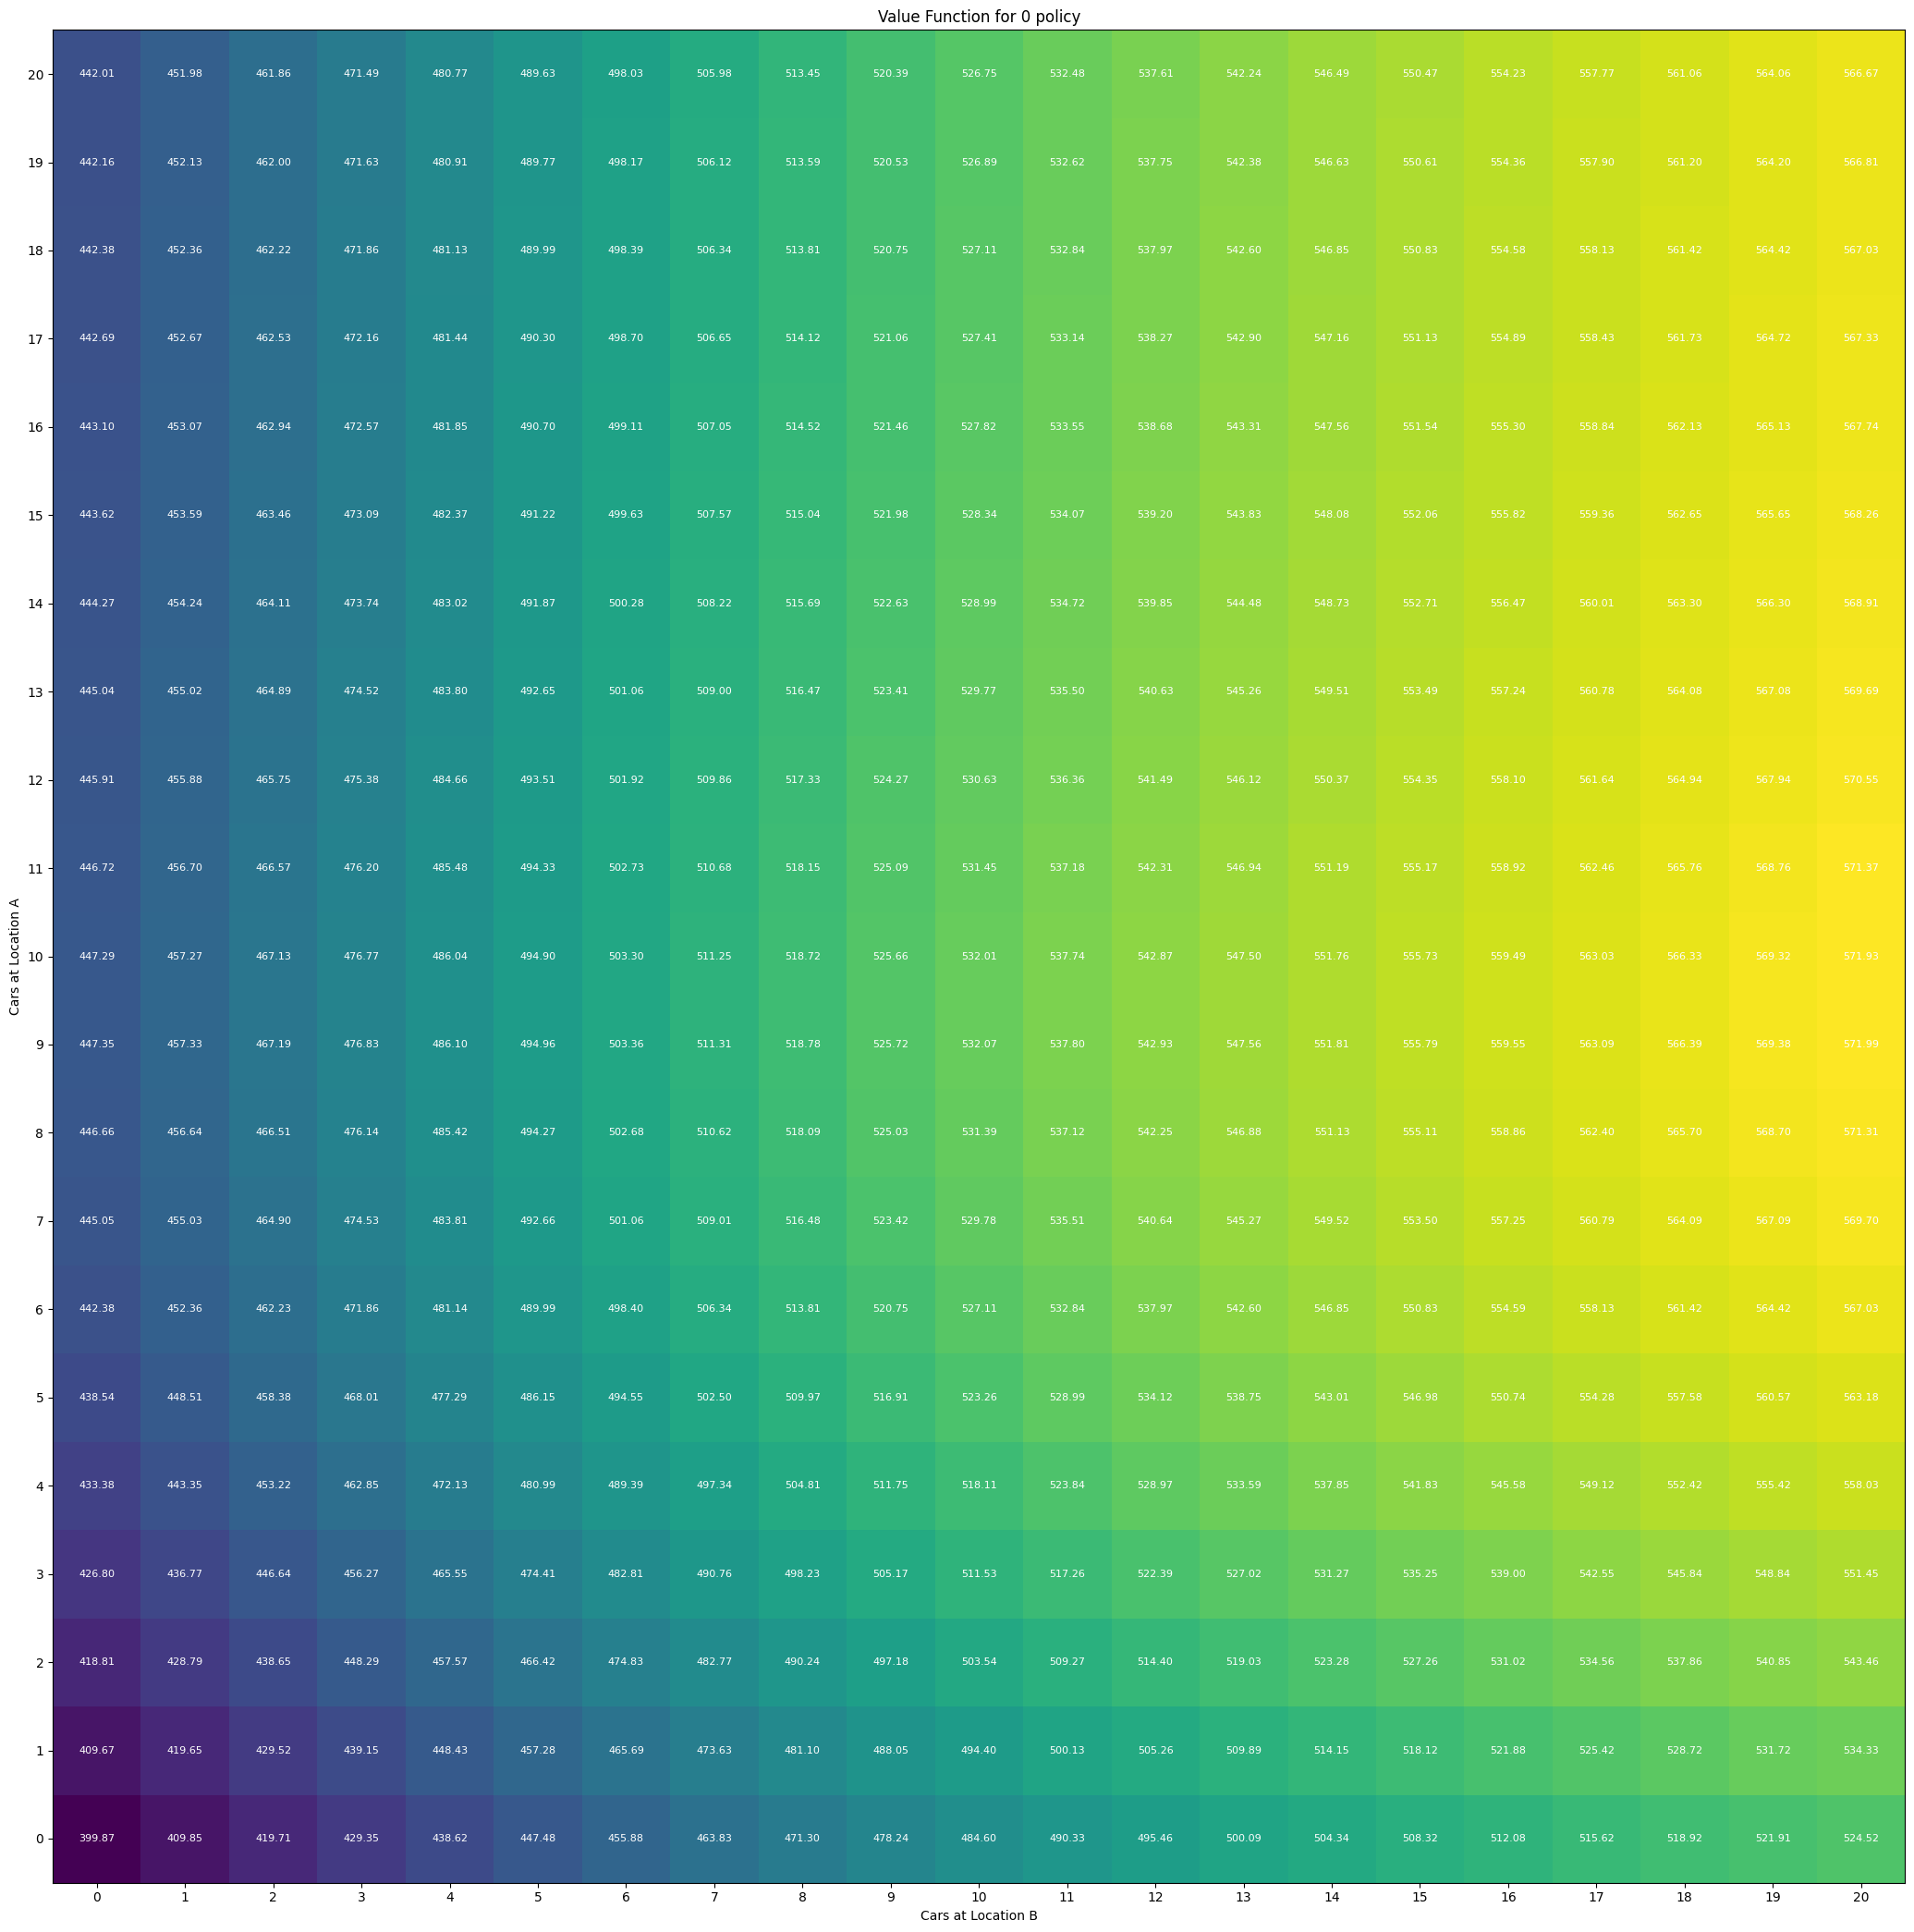

**********Staring 1 iteration


441it [00:00, 126595.58it/s]


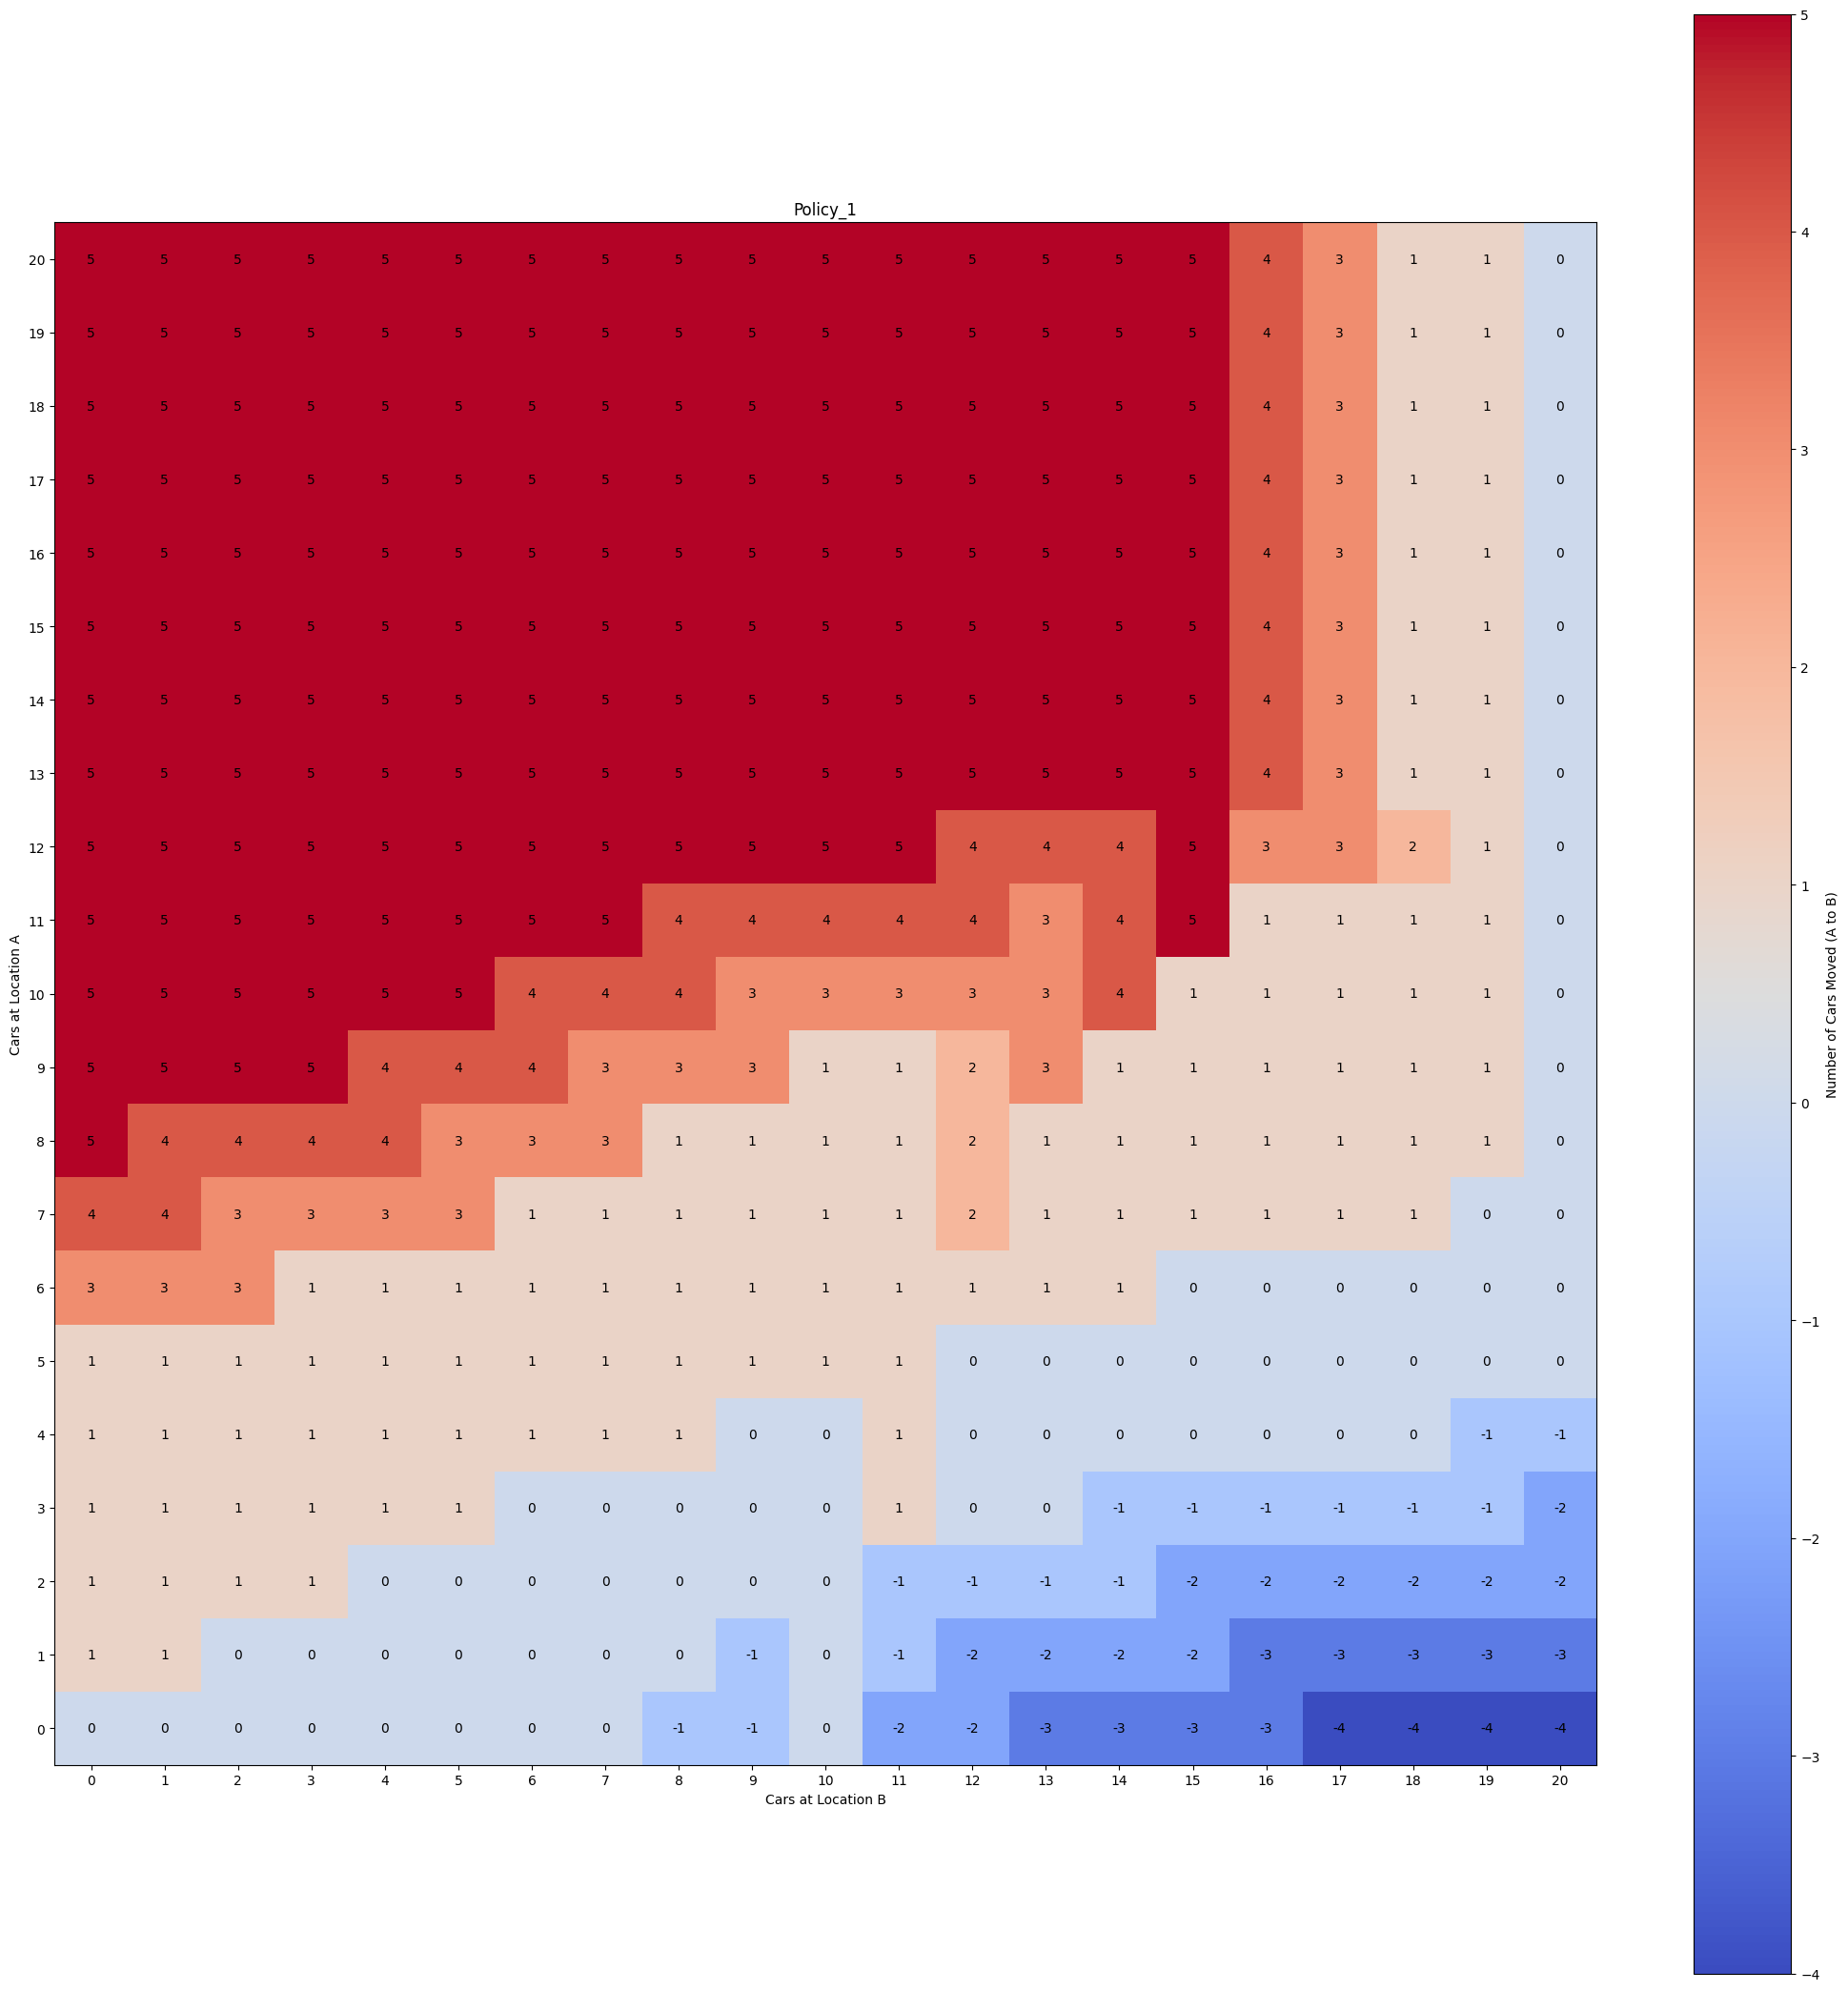

Conduct 1 time evaluation


441it [00:08, 52.87it/s] 


69.31843990510089


441it [00:08, 52.15it/s] 


6.766620268800466


441it [00:08, 52.43it/s] 


4.106538559454975


441it [00:08, 52.50it/s] 


2.8729172539403294


441it [00:08, 52.15it/s] 


2.4275338276034404


441it [00:08, 52.00it/s] 


2.020316821709457


441it [00:08, 51.92it/s] 


1.6687219808164855


441it [00:08, 52.13it/s] 


1.373905008219083


441it [00:08, 51.85it/s] 


1.1294147898557299


441it [00:08, 52.33it/s] 


0.9276514094843265


441it [00:08, 51.95it/s] 


0.761559331410524


441it [00:08, 52.41it/s] 


0.625018651274047


441it [00:08, 51.66it/s] 


0.5128616915411044


441it [00:08, 52.02it/s] 


0.42077946581645165


441it [00:08, 52.09it/s] 


0.3452025414953255


441it [00:08, 51.90it/s] 


0.2831850342255393


441it [00:08, 51.90it/s] 


0.23230103090418197


441it [00:08, 51.79it/s] 


0.19055553767464062


441it [00:08, 51.80it/s] 


0.15630936377641547


441it [00:08, 52.01it/s] 


0.12821642794693844


441it [00:08, 52.01it/s] 


0.10517175948598378


441it [00:08, 52.22it/s] 


0.0862685359930424


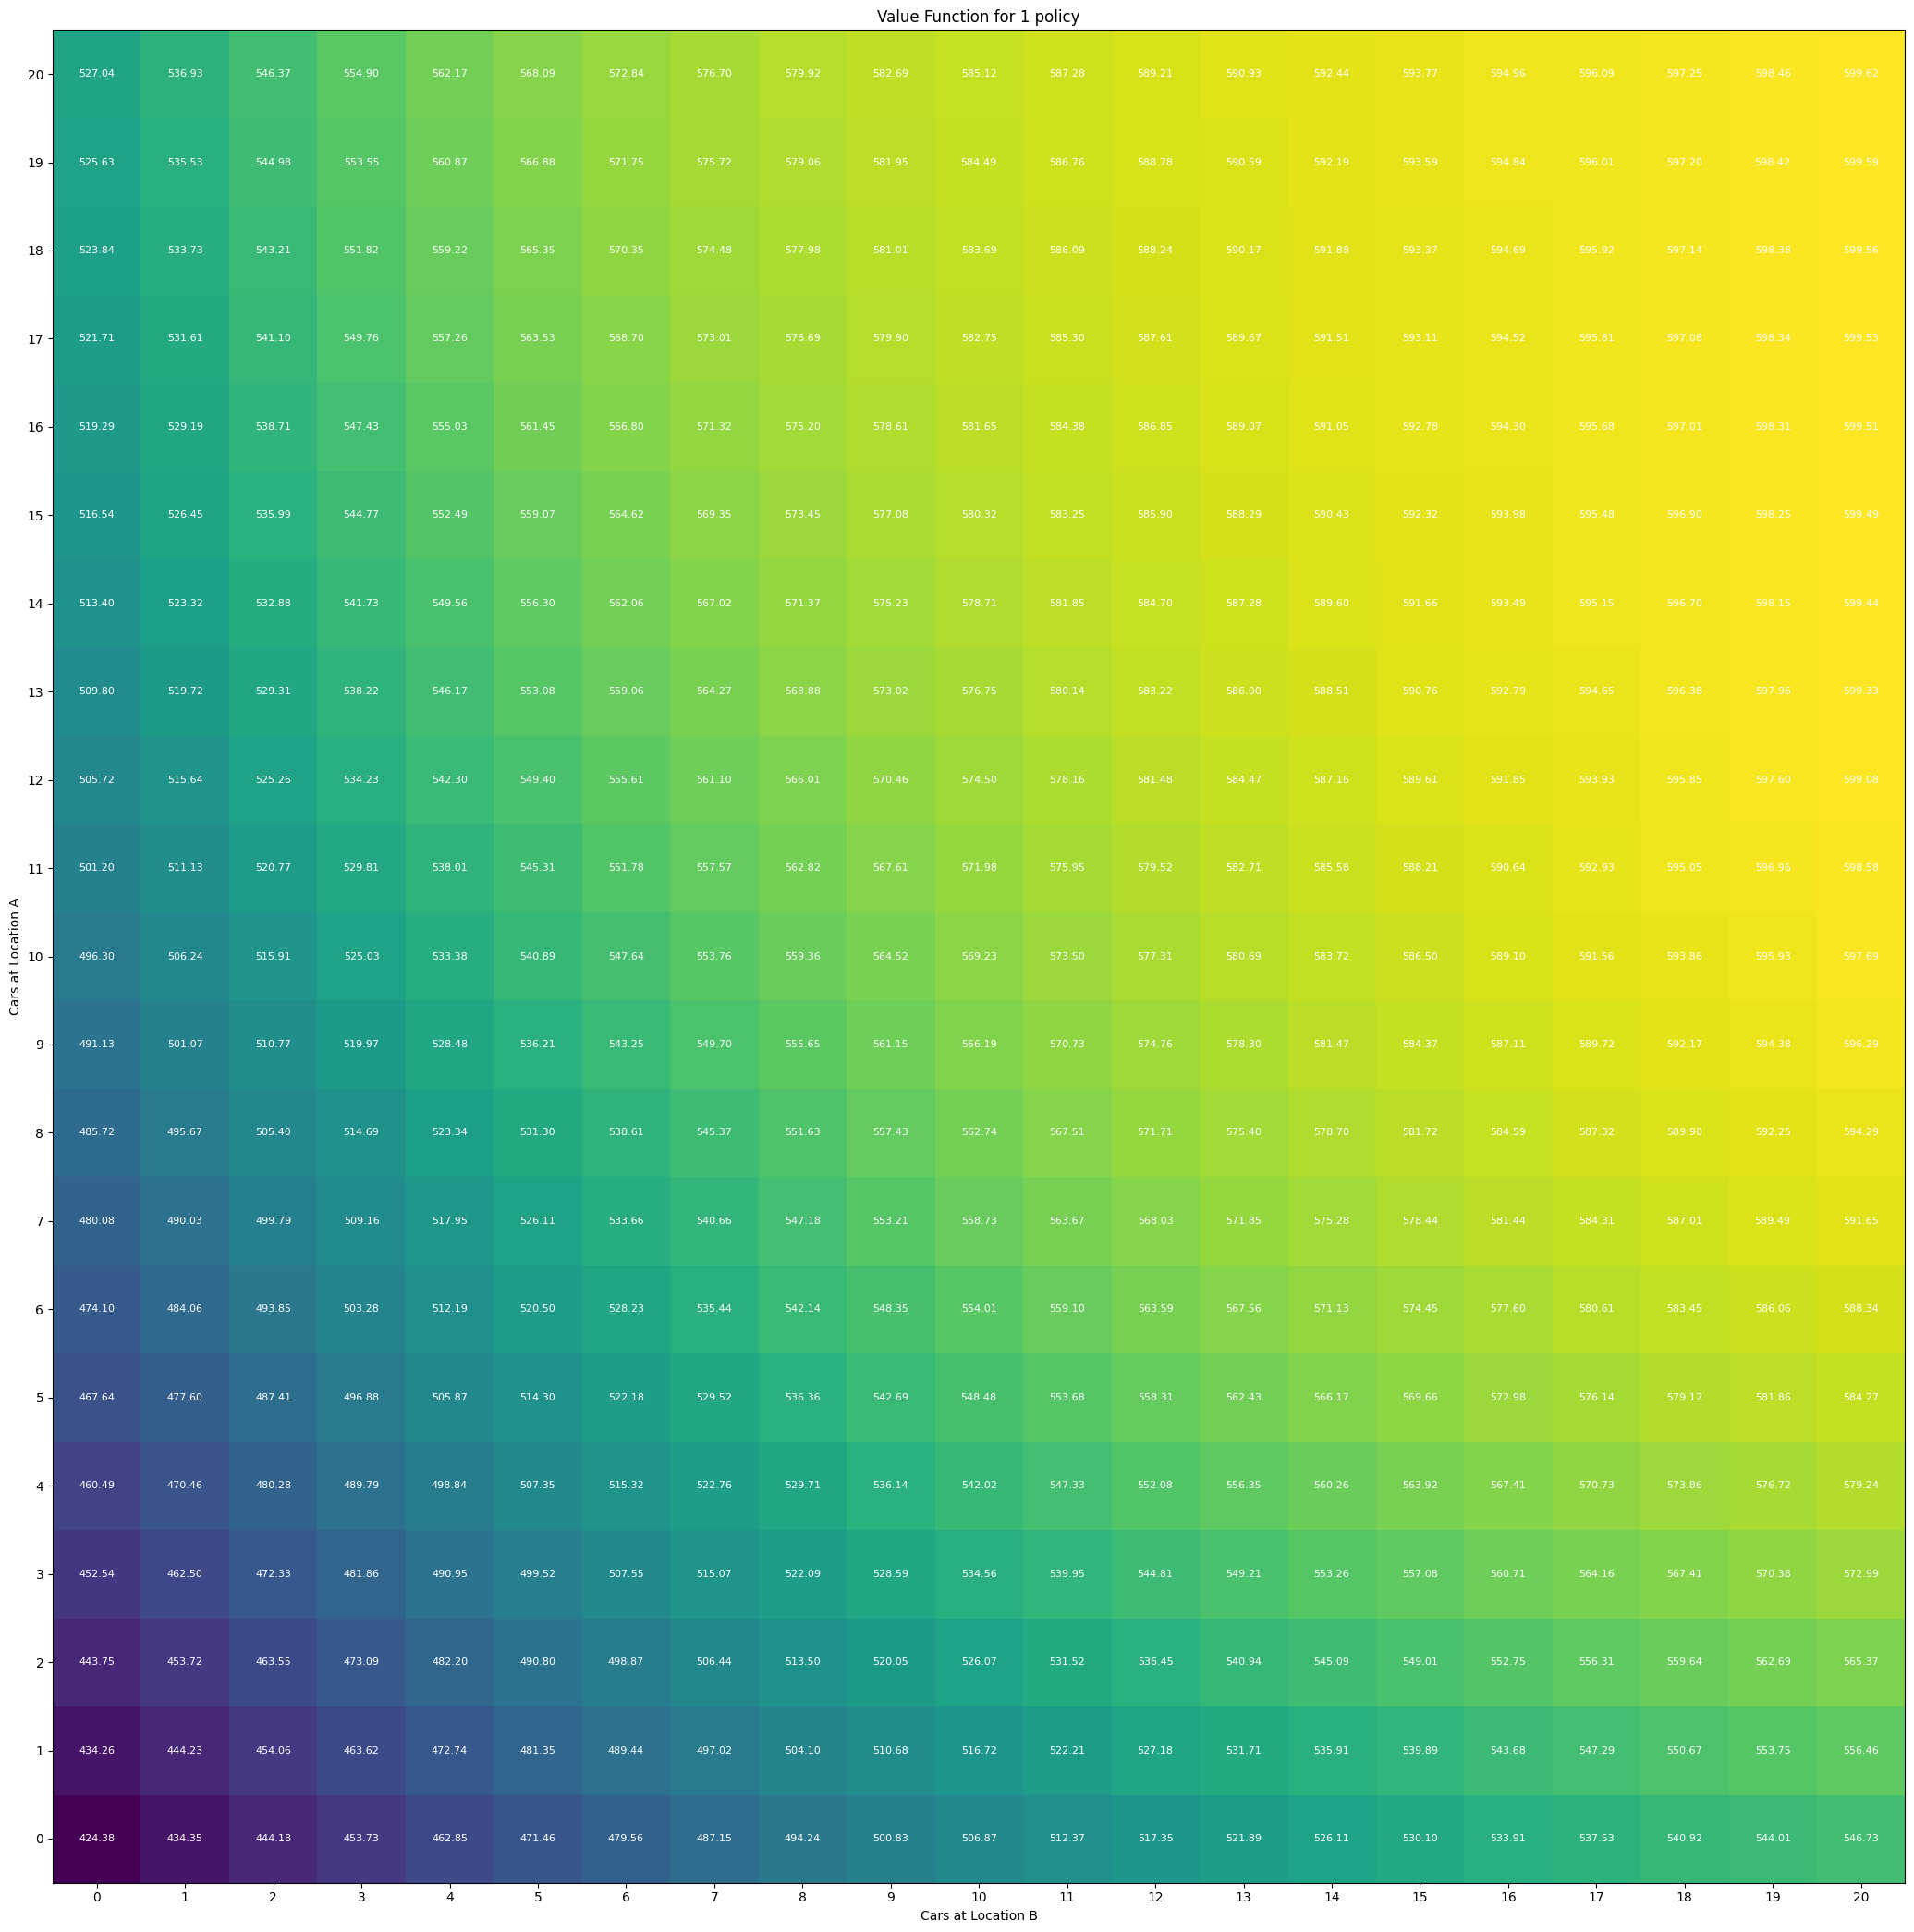

**********Staring 2 iteration


441it [00:00, 147057.41it/s]


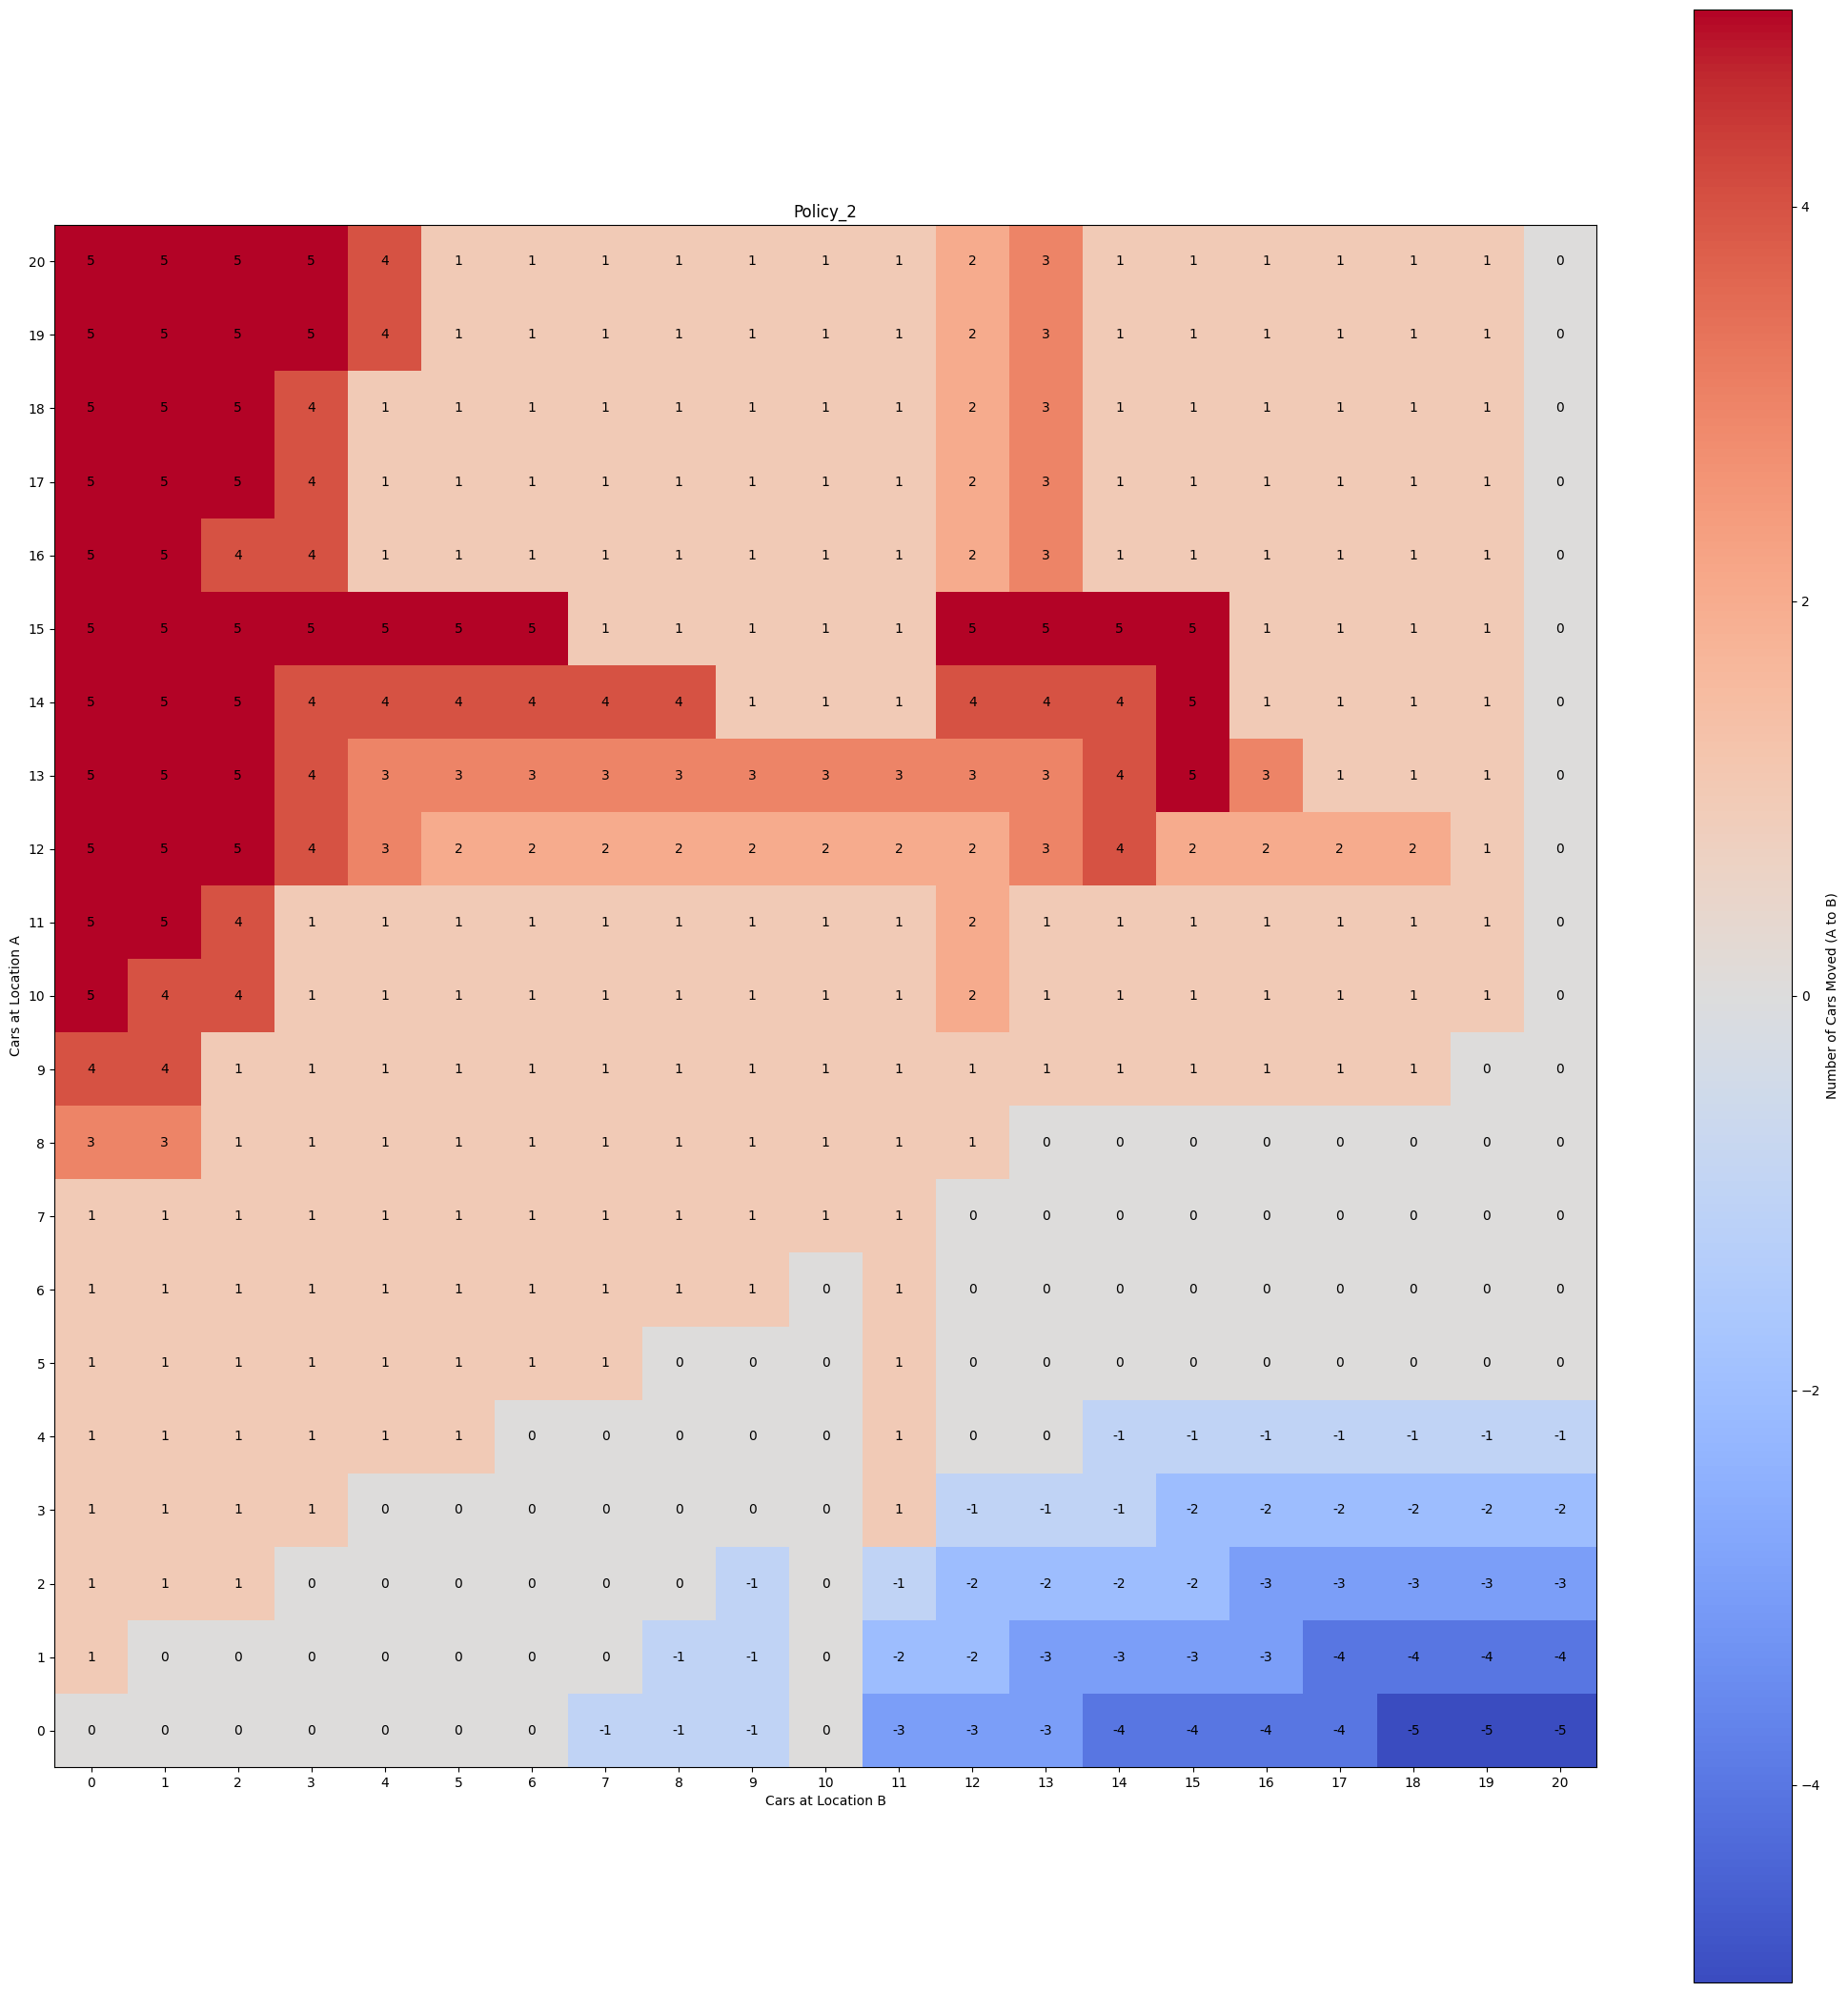

Conduct 2 time evaluation


441it [00:08, 52.15it/s] 


7.966174242487682


441it [00:08, 52.28it/s] 


3.183827963219528


441it [00:08, 52.56it/s] 


1.6732385327917427


441it [00:08, 52.72it/s] 


1.0694866665995733


441it [00:08, 52.68it/s] 


0.7108483933961907


441it [00:08, 52.61it/s] 


0.5390657194077448


441it [00:08, 52.78it/s] 


0.40587422075657287


441it [00:08, 52.56it/s] 


0.31108758947635806


441it [00:08, 52.66it/s] 


0.25780017610048844


441it [00:08, 52.38it/s] 


0.2126425559412155


441it [00:08, 52.85it/s] 


0.1749349800053892


441it [00:08, 52.77it/s] 


0.14369715604436806


441it [00:08, 52.71it/s] 


0.11793265524045182


441it [00:08, 53.23it/s] 


0.09673584889929998


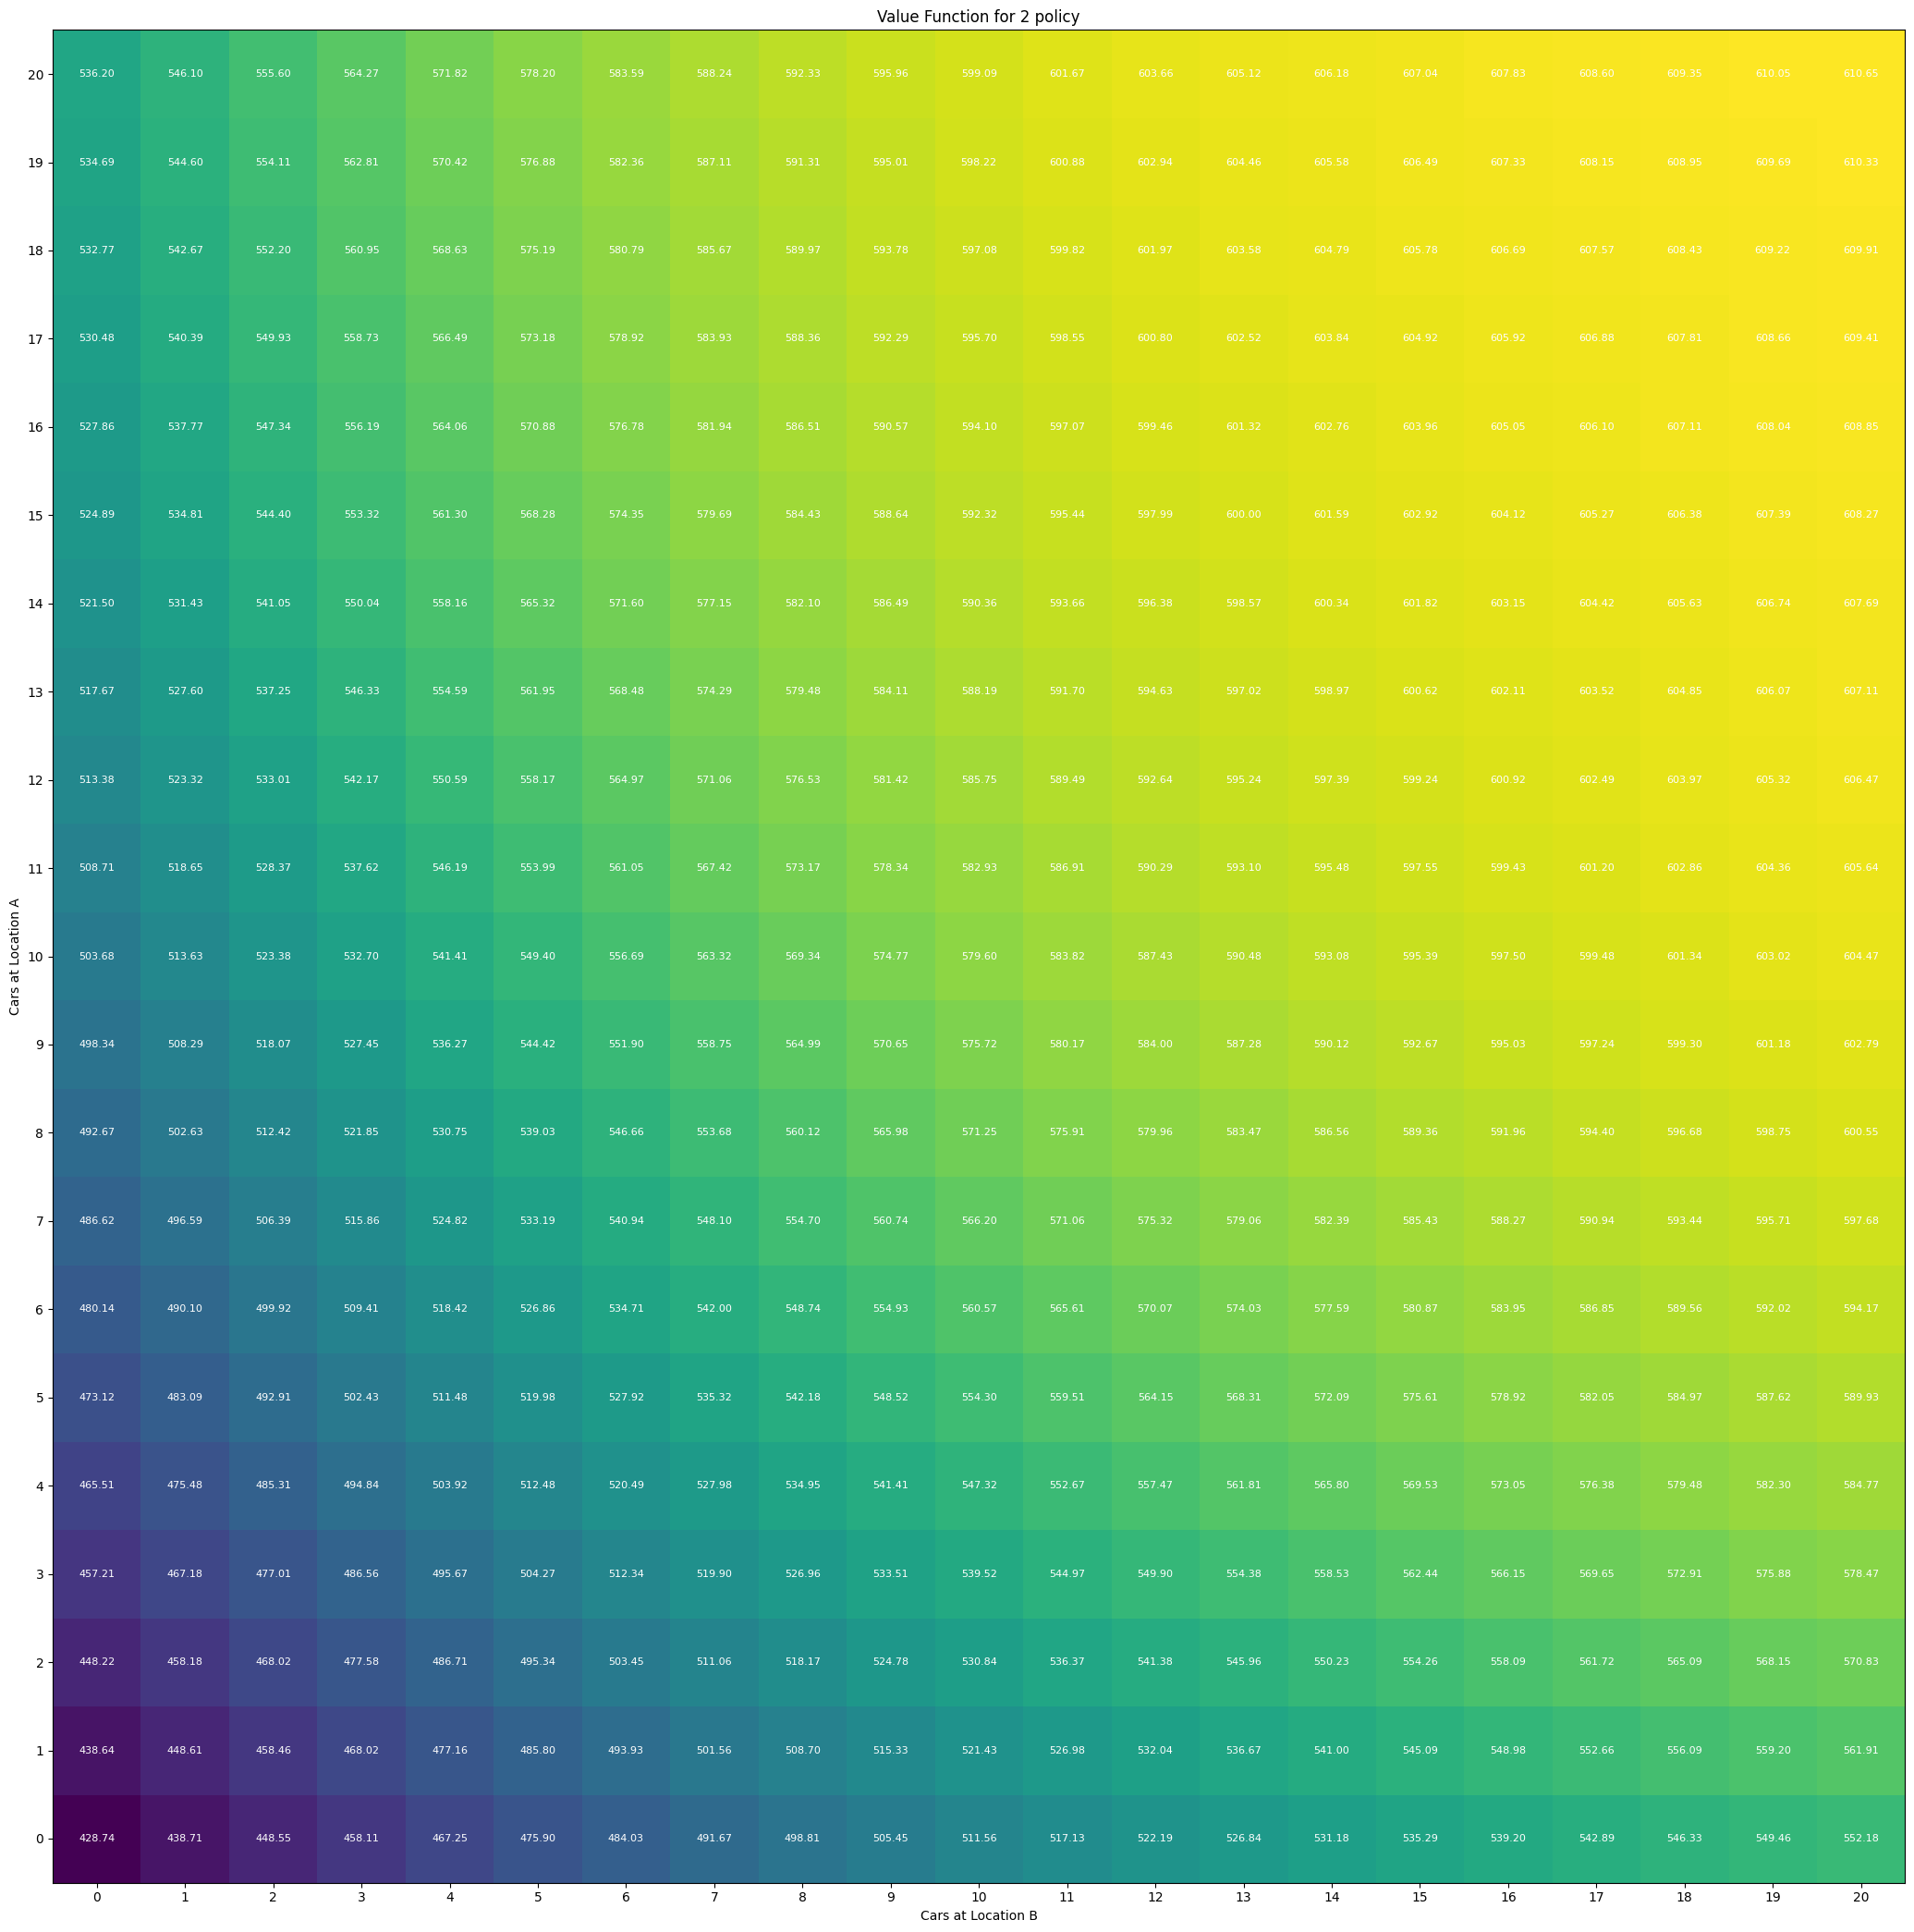

**********Staring 3 iteration


441it [00:00, 110264.56it/s]


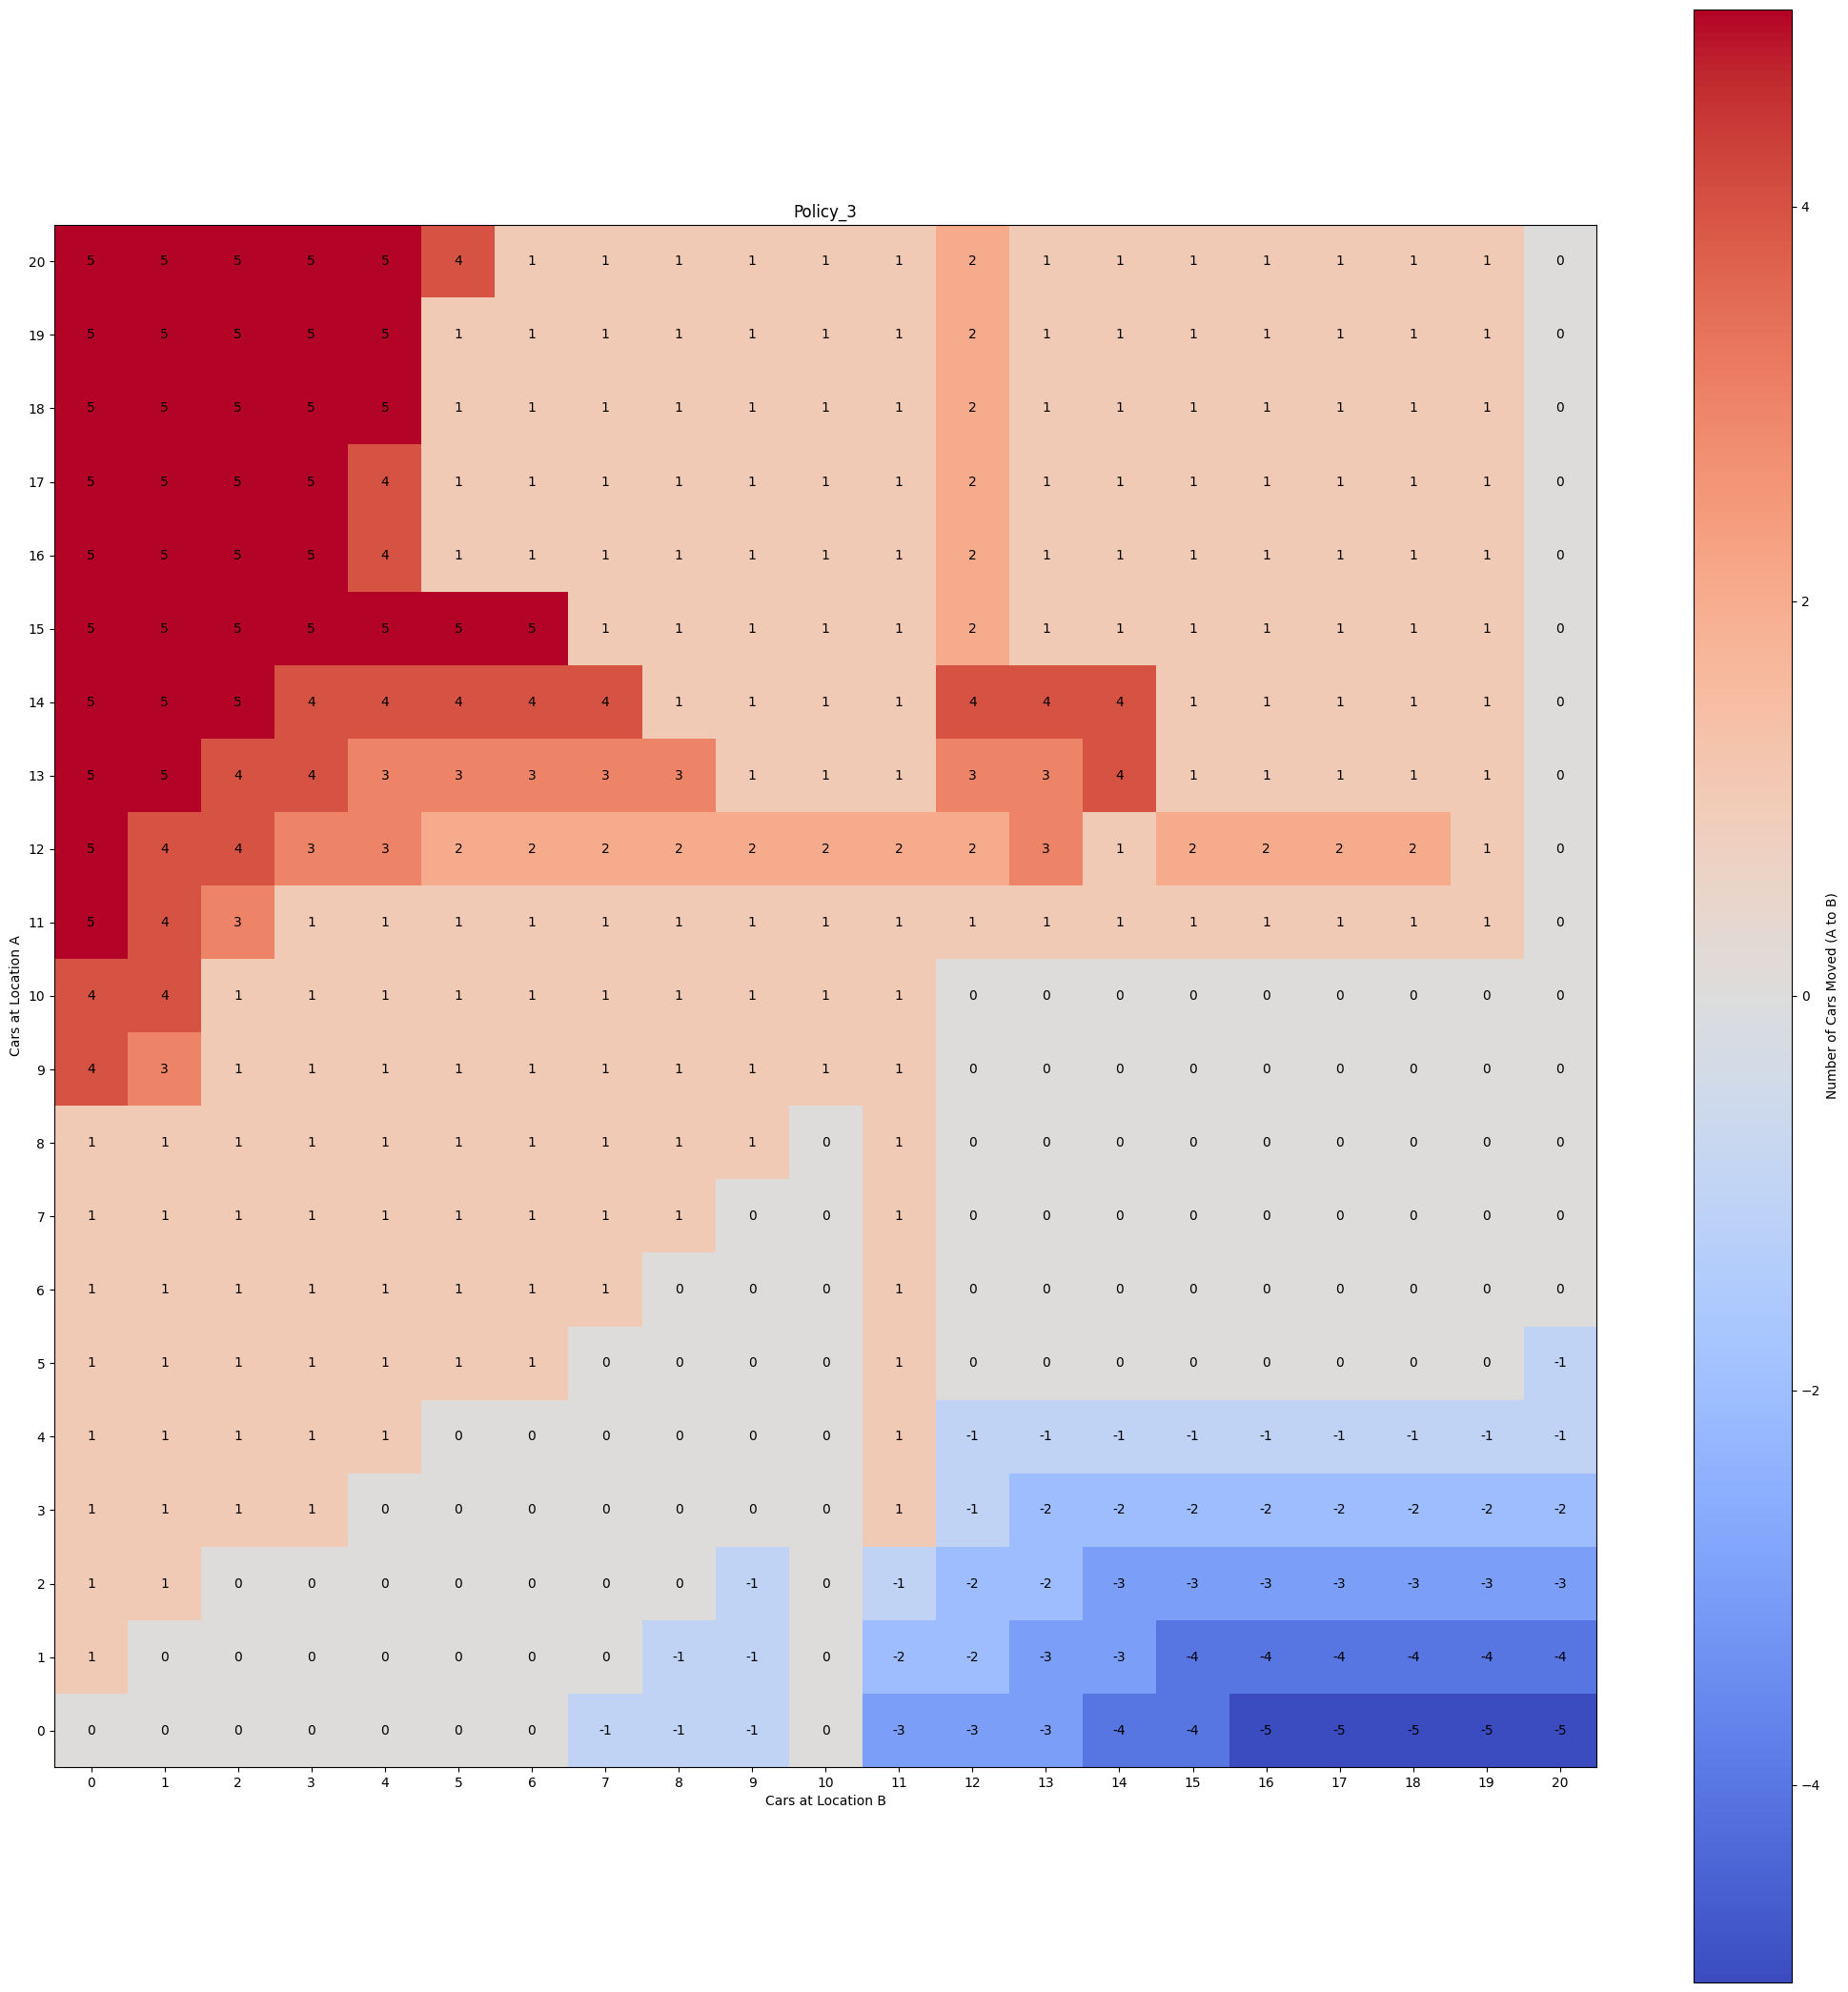

Conduct 3 time evaluation


441it [00:08, 53.11it/s] 


0.6822621801568403


441it [00:08, 53.03it/s] 


0.3047572275463608


441it [00:08, 52.64it/s] 


0.19328379226851666


441it [00:08, 49.82it/s] 


0.12315345708498171


441it [00:08, 53.56it/s] 


0.07917392700539949


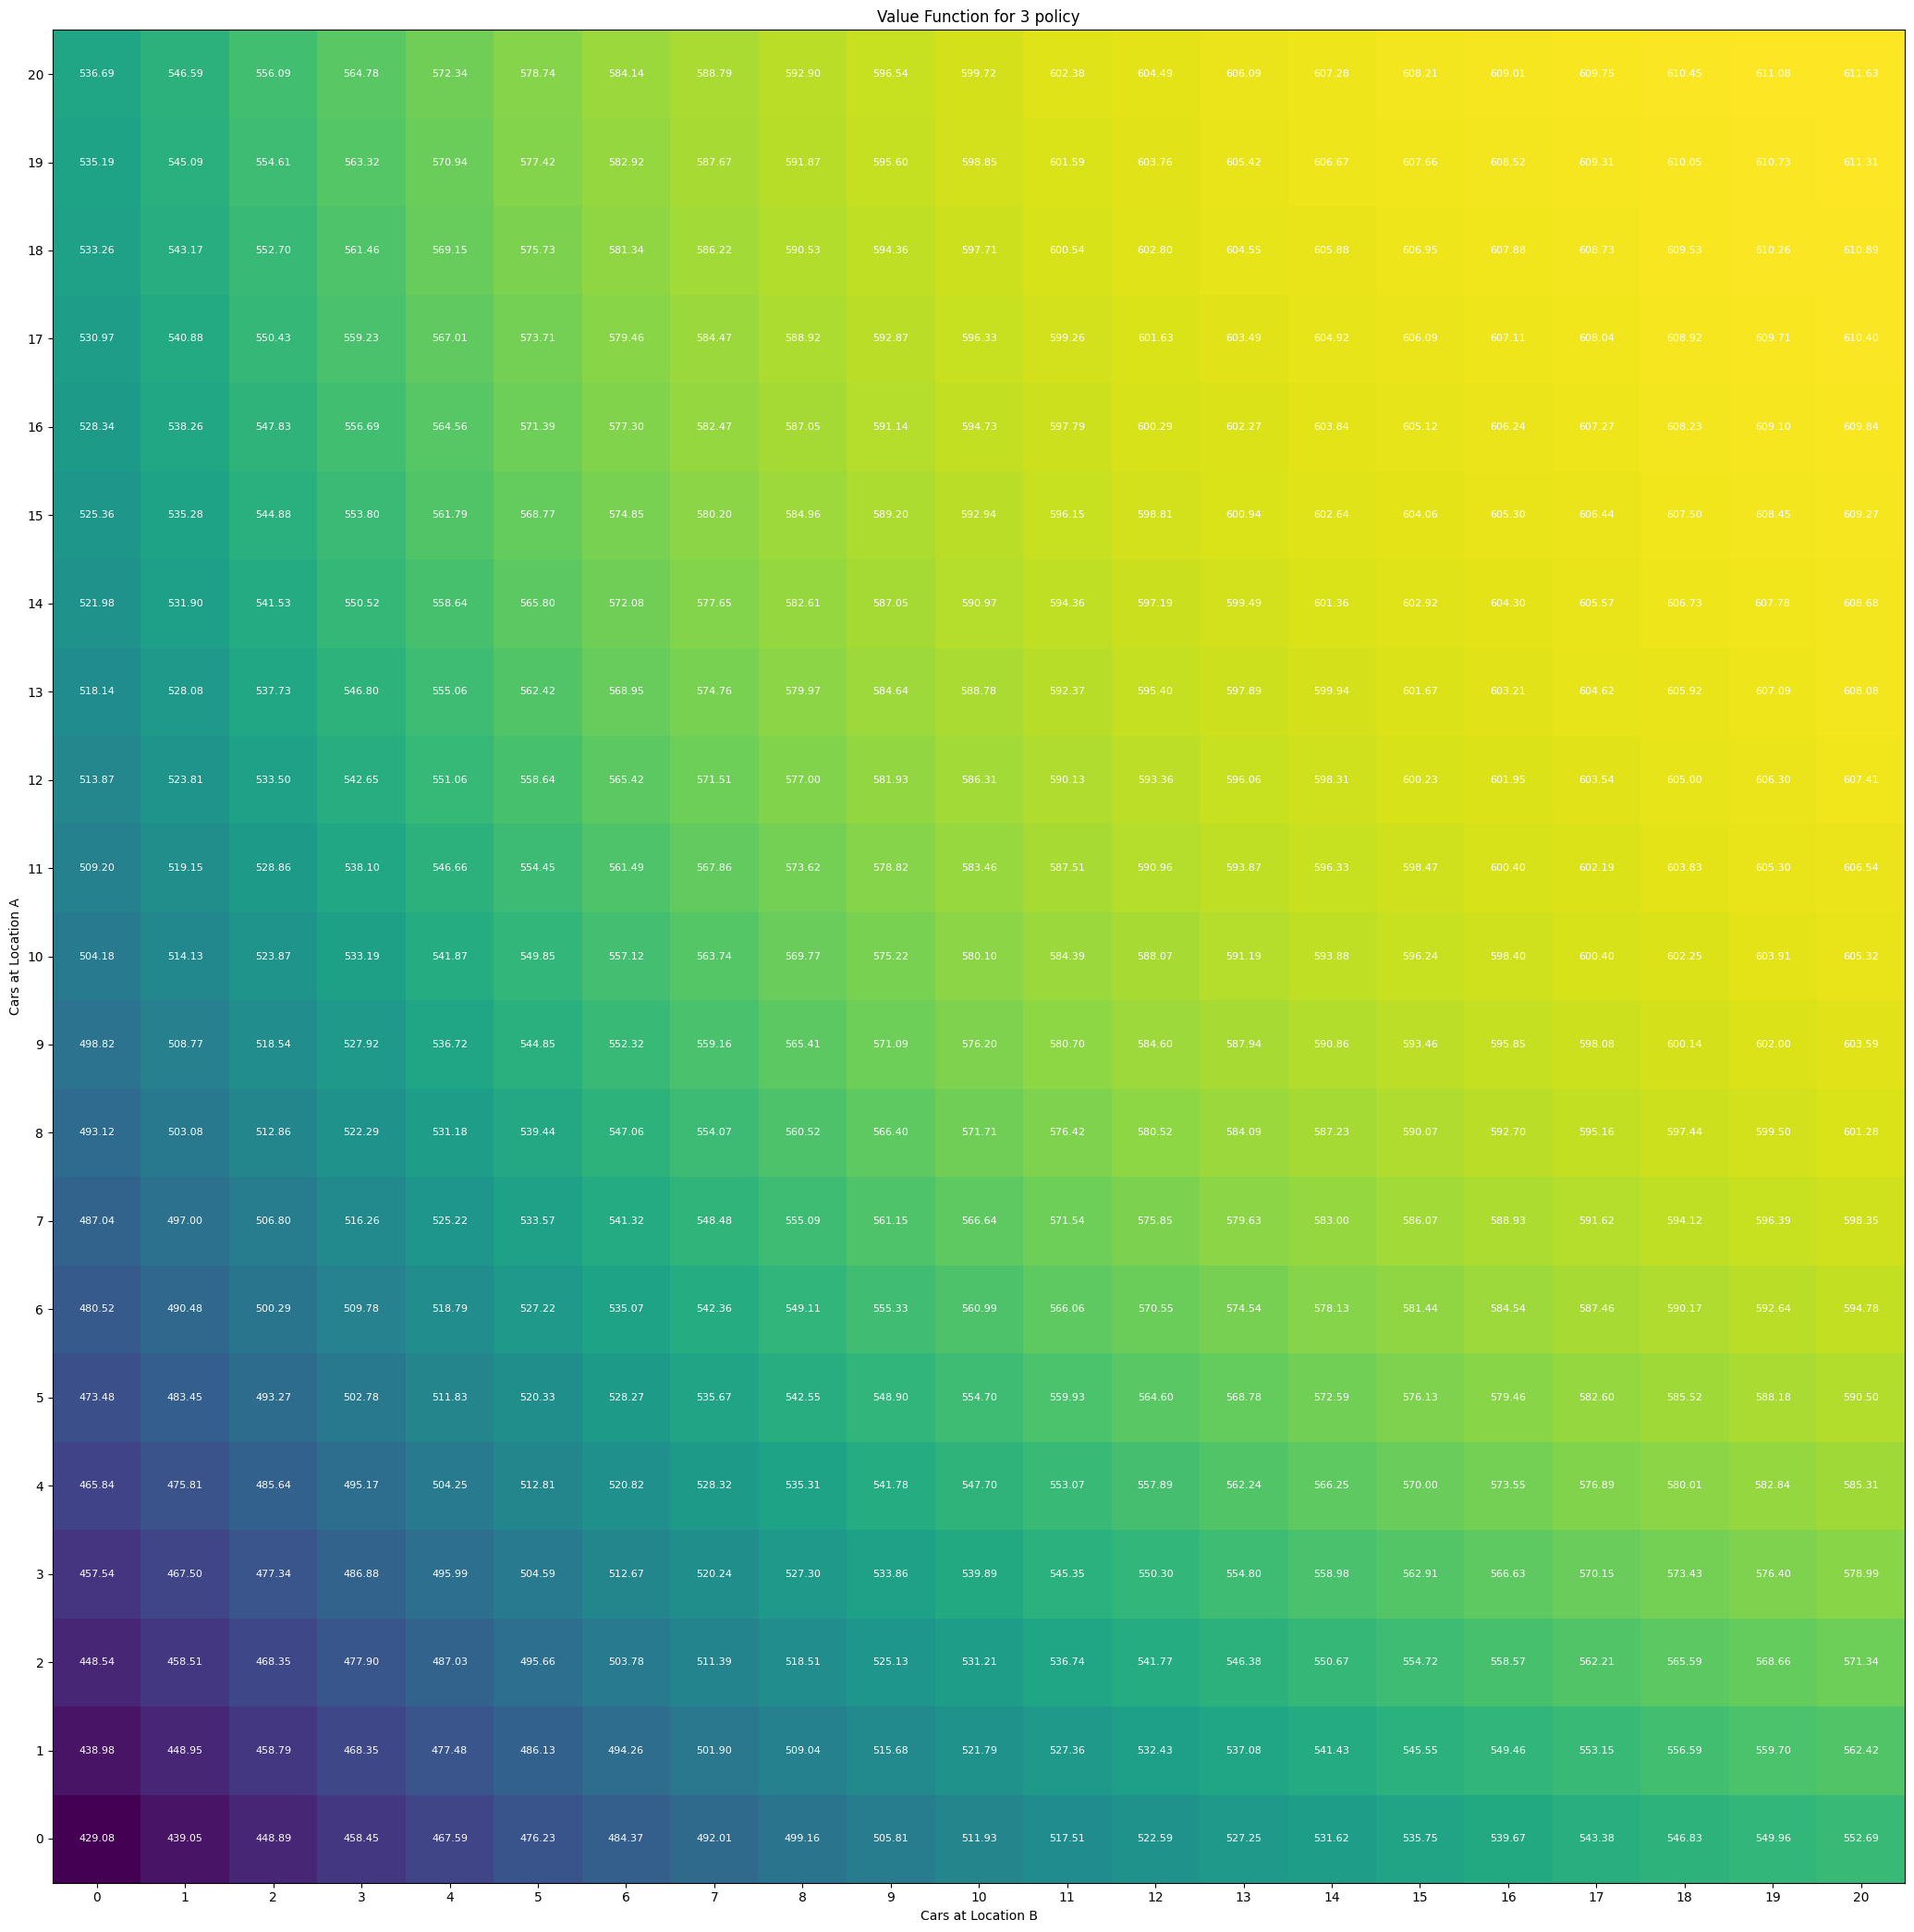

**********Staring 4 iteration


441it [00:00, 117105.92it/s]


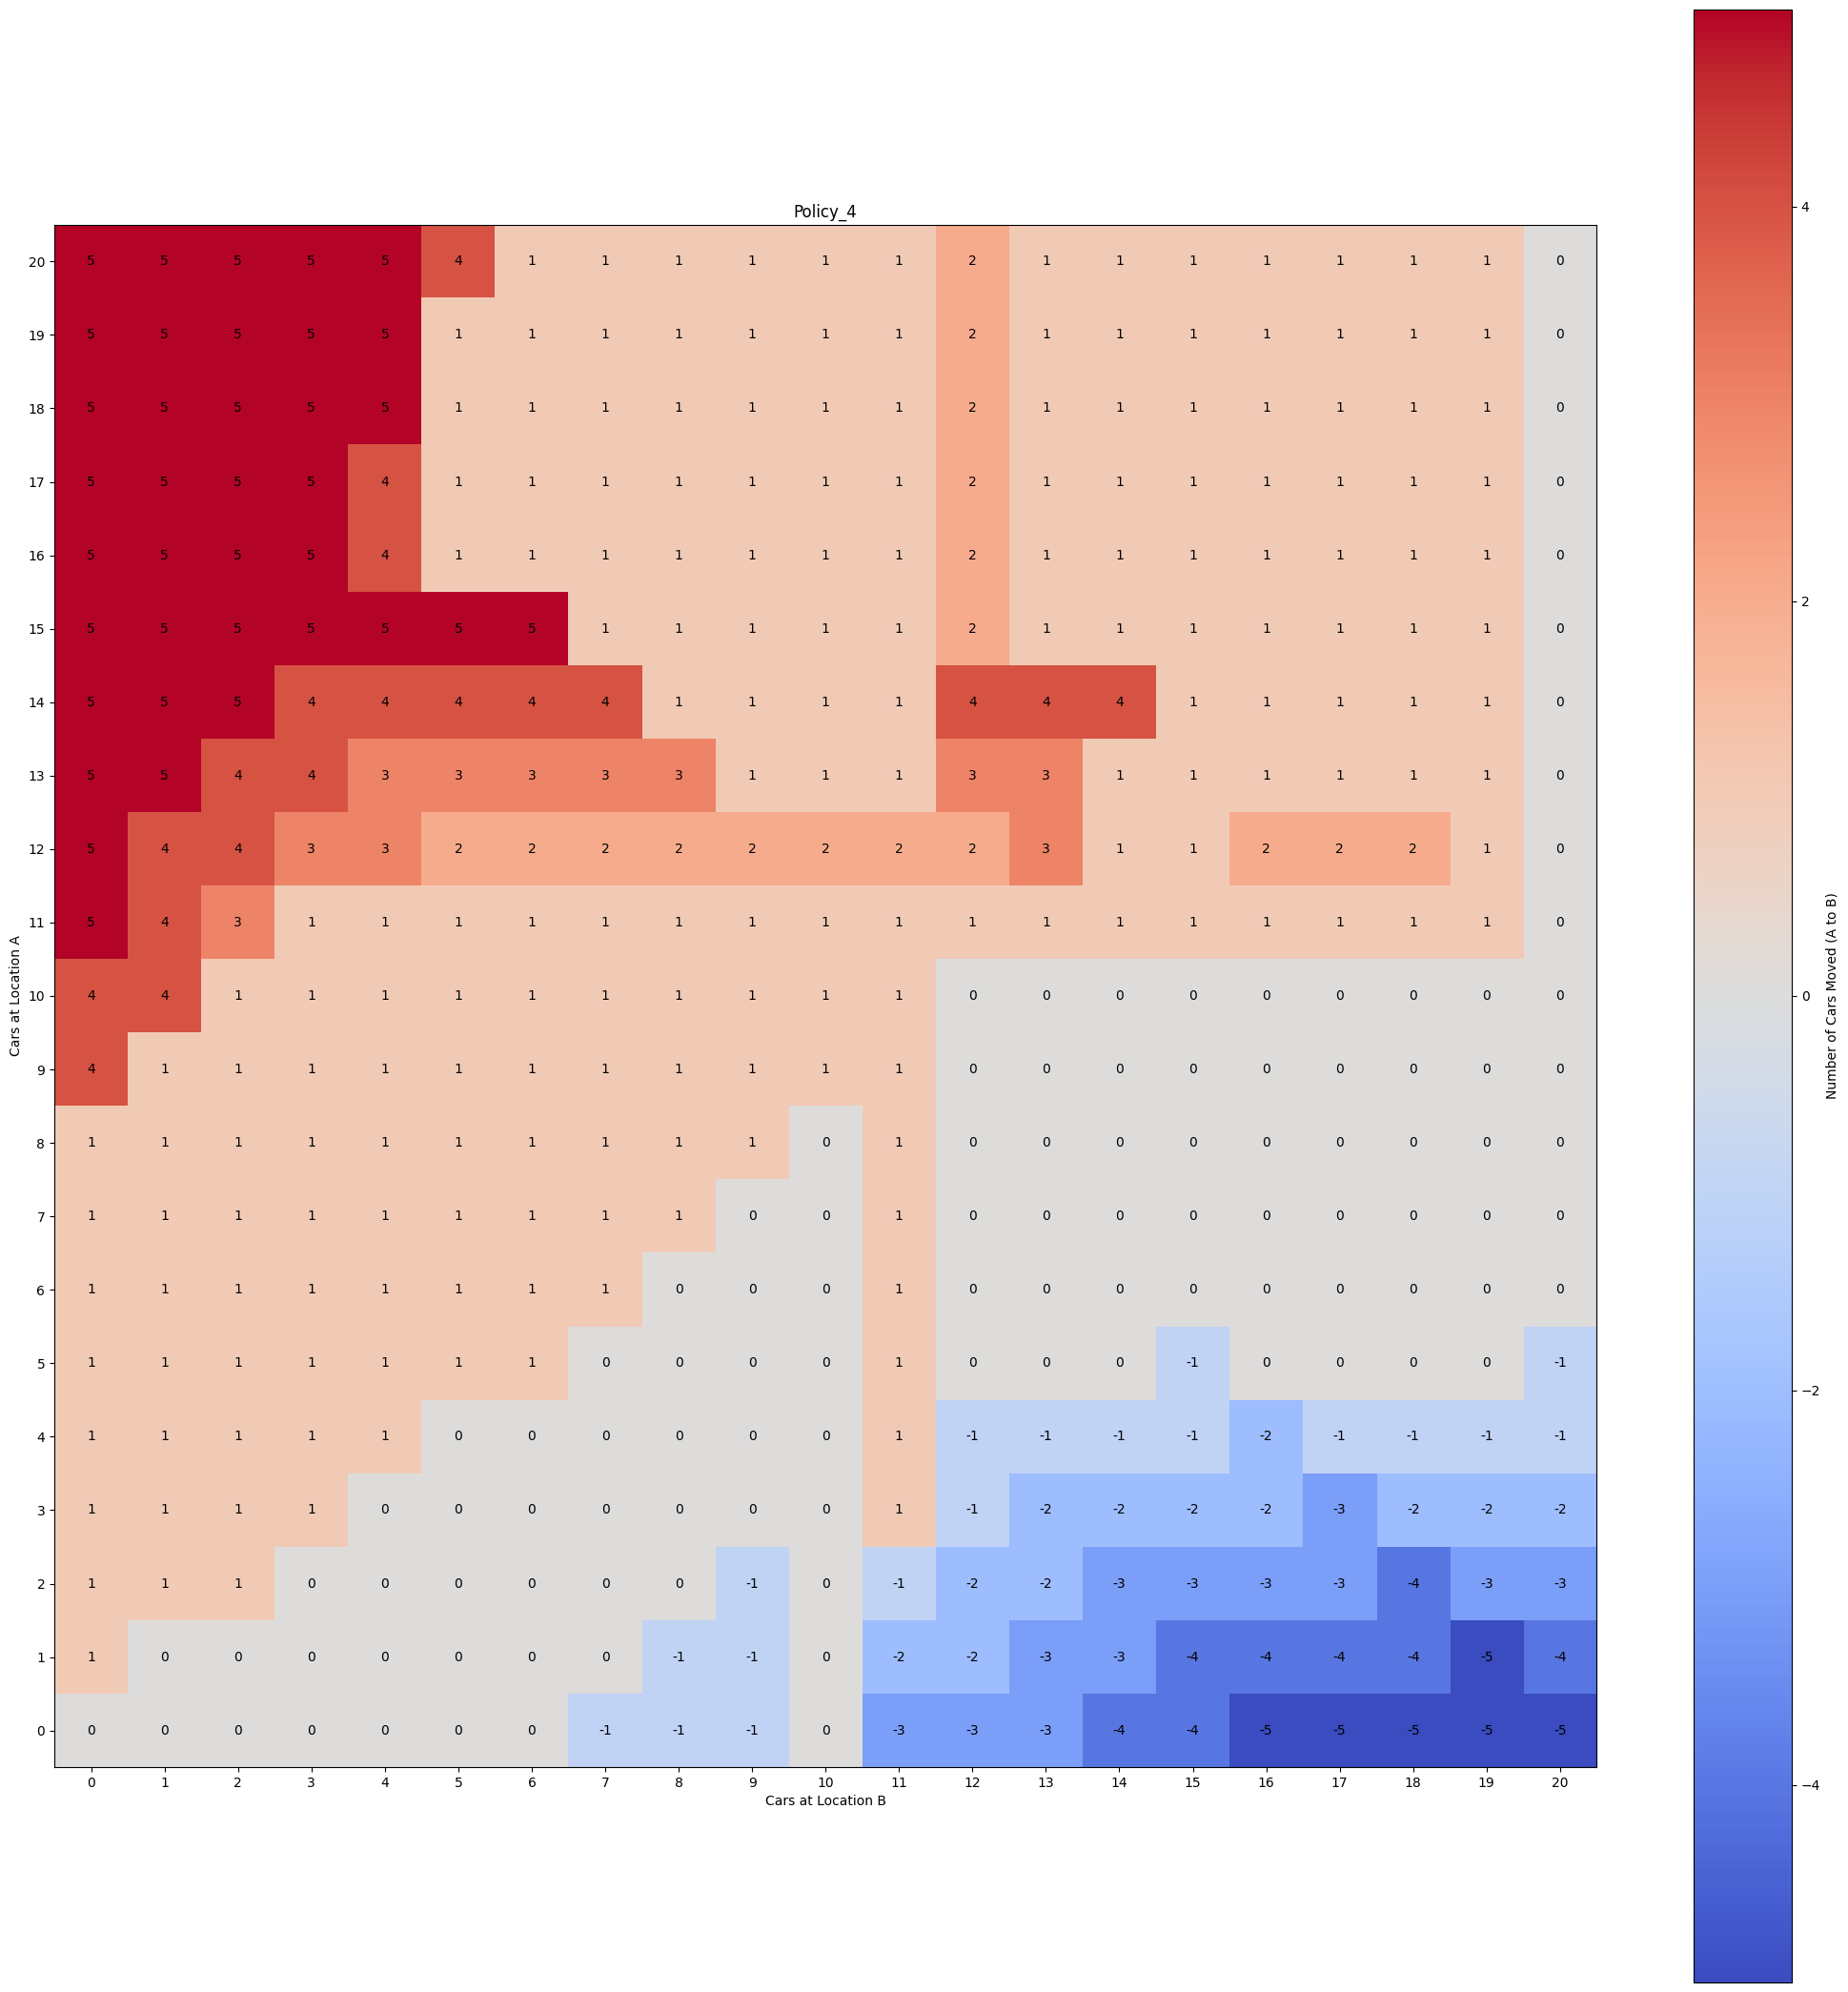

Conduct 4 time evaluation


441it [00:08, 53.38it/s] 


0.05405366902948572


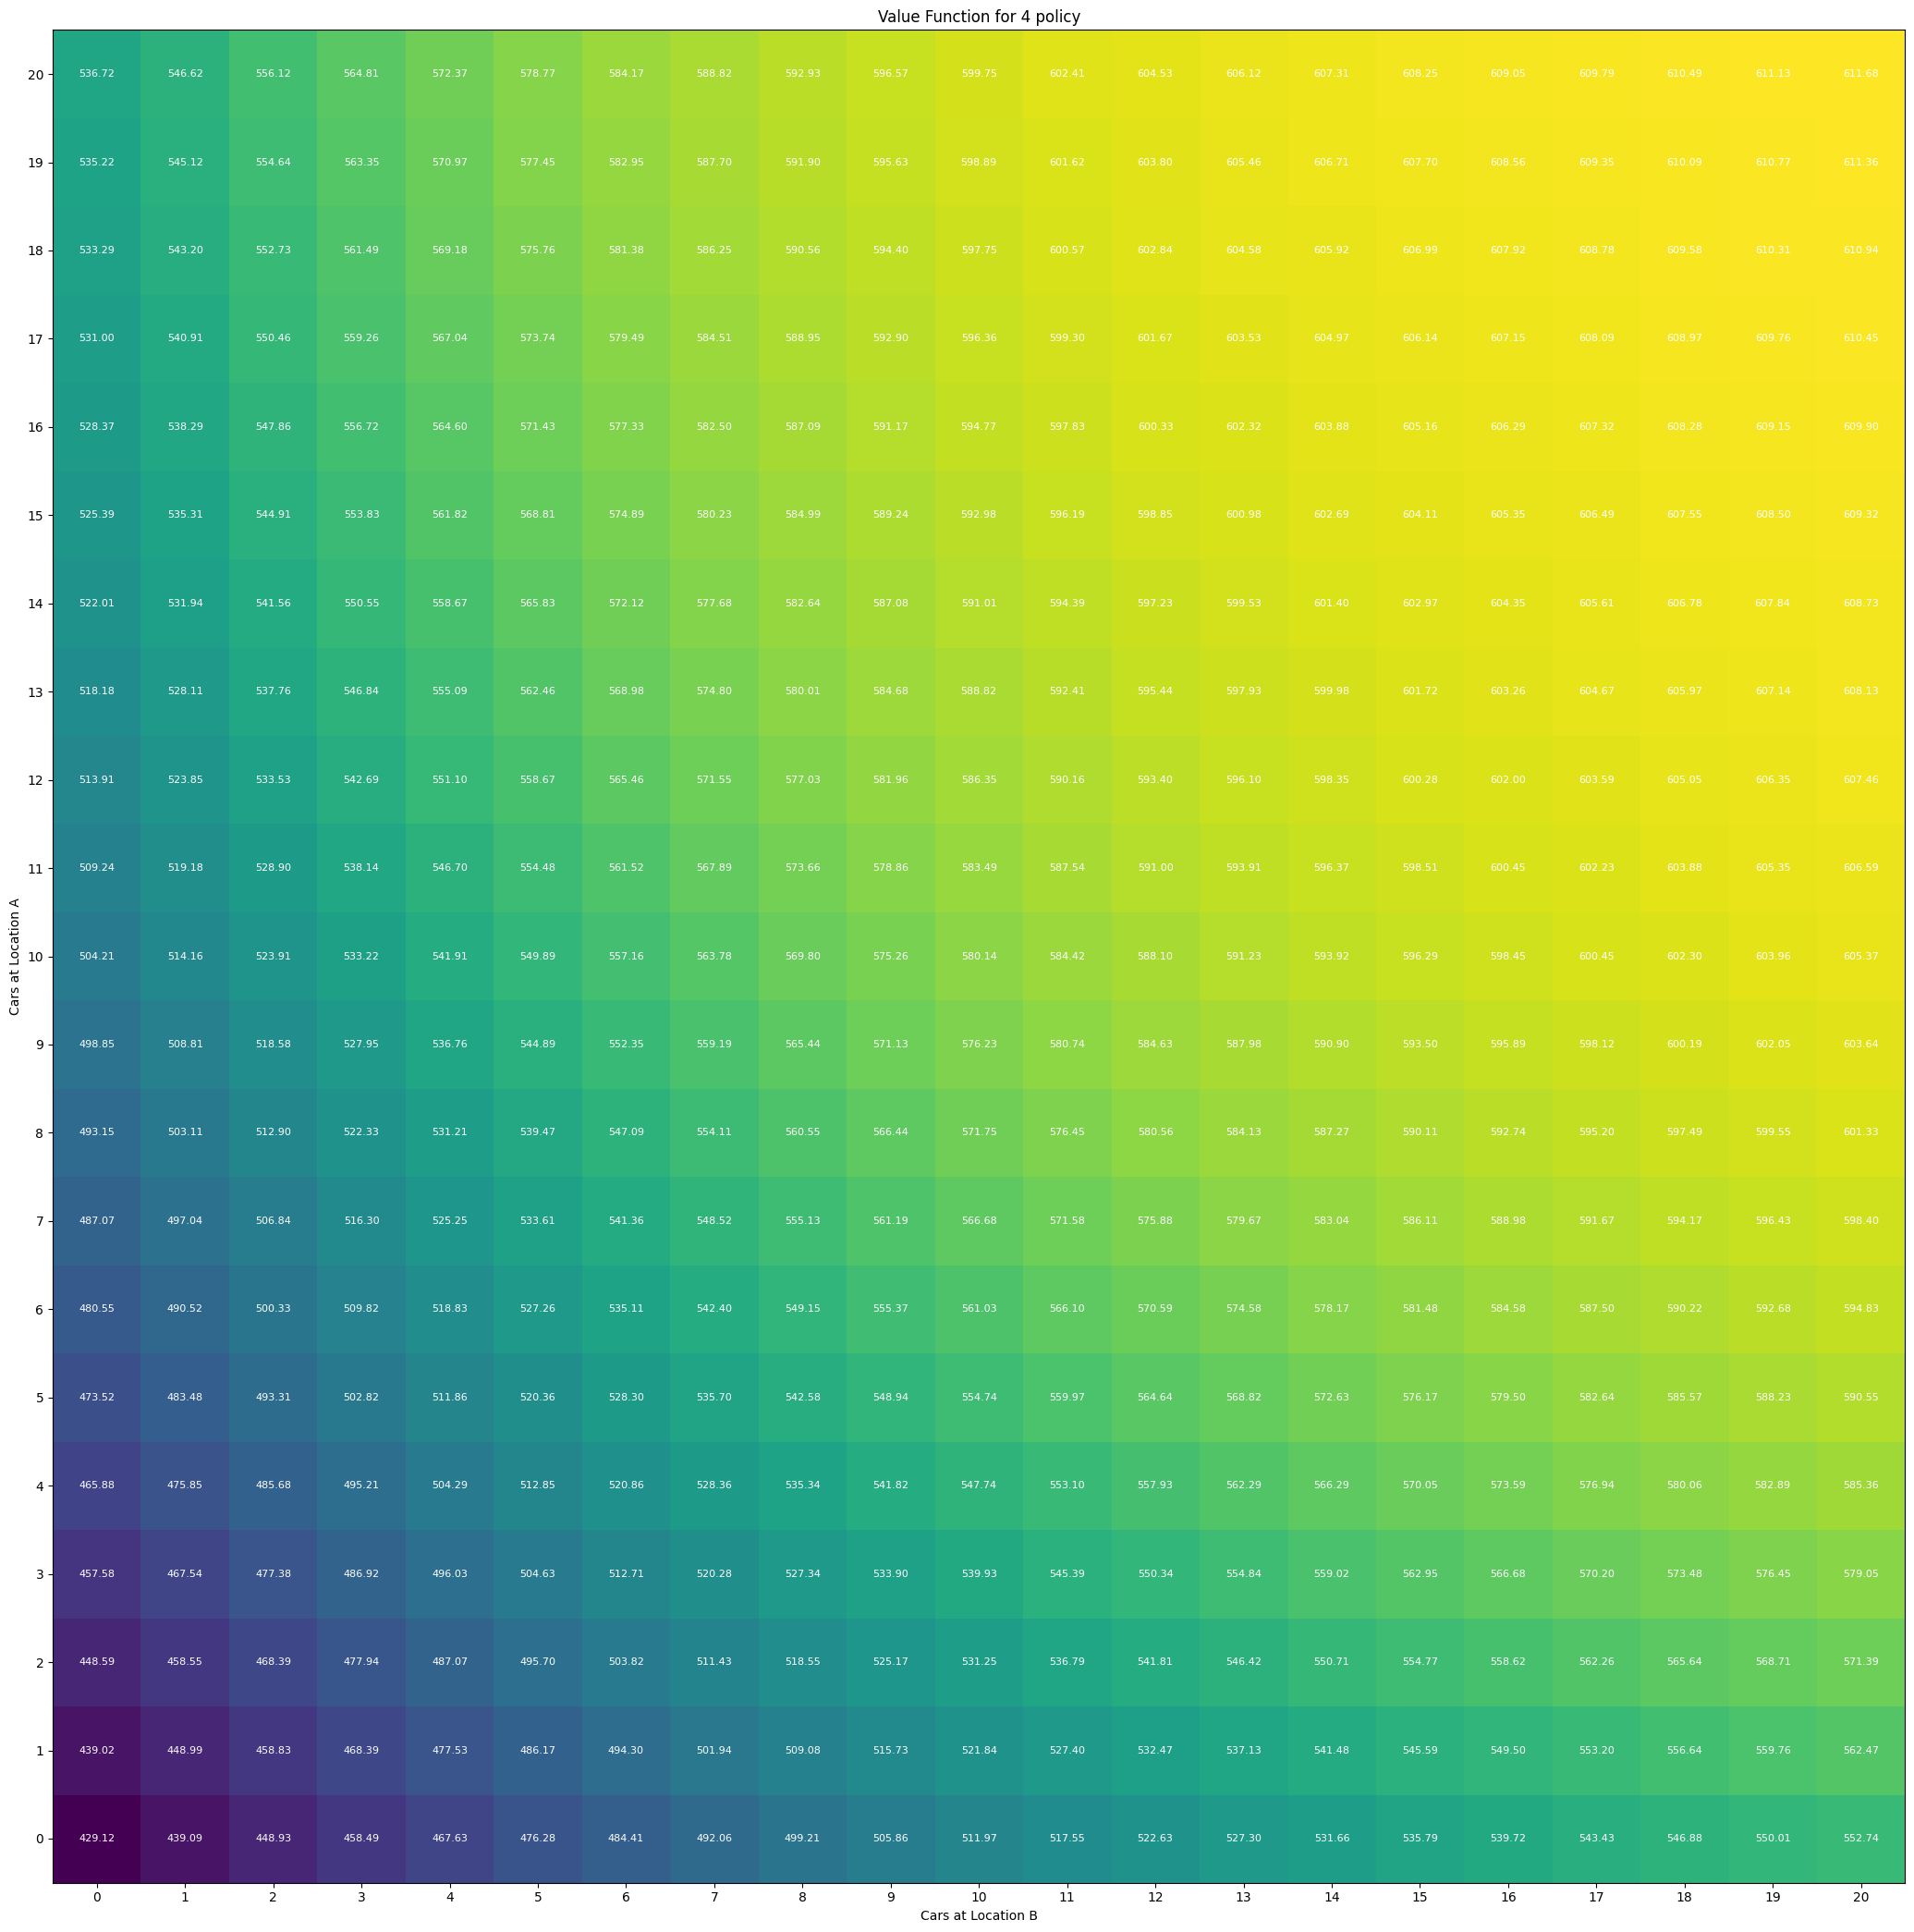

**********Staring 5 iteration


441it [00:00, 125726.49it/s]


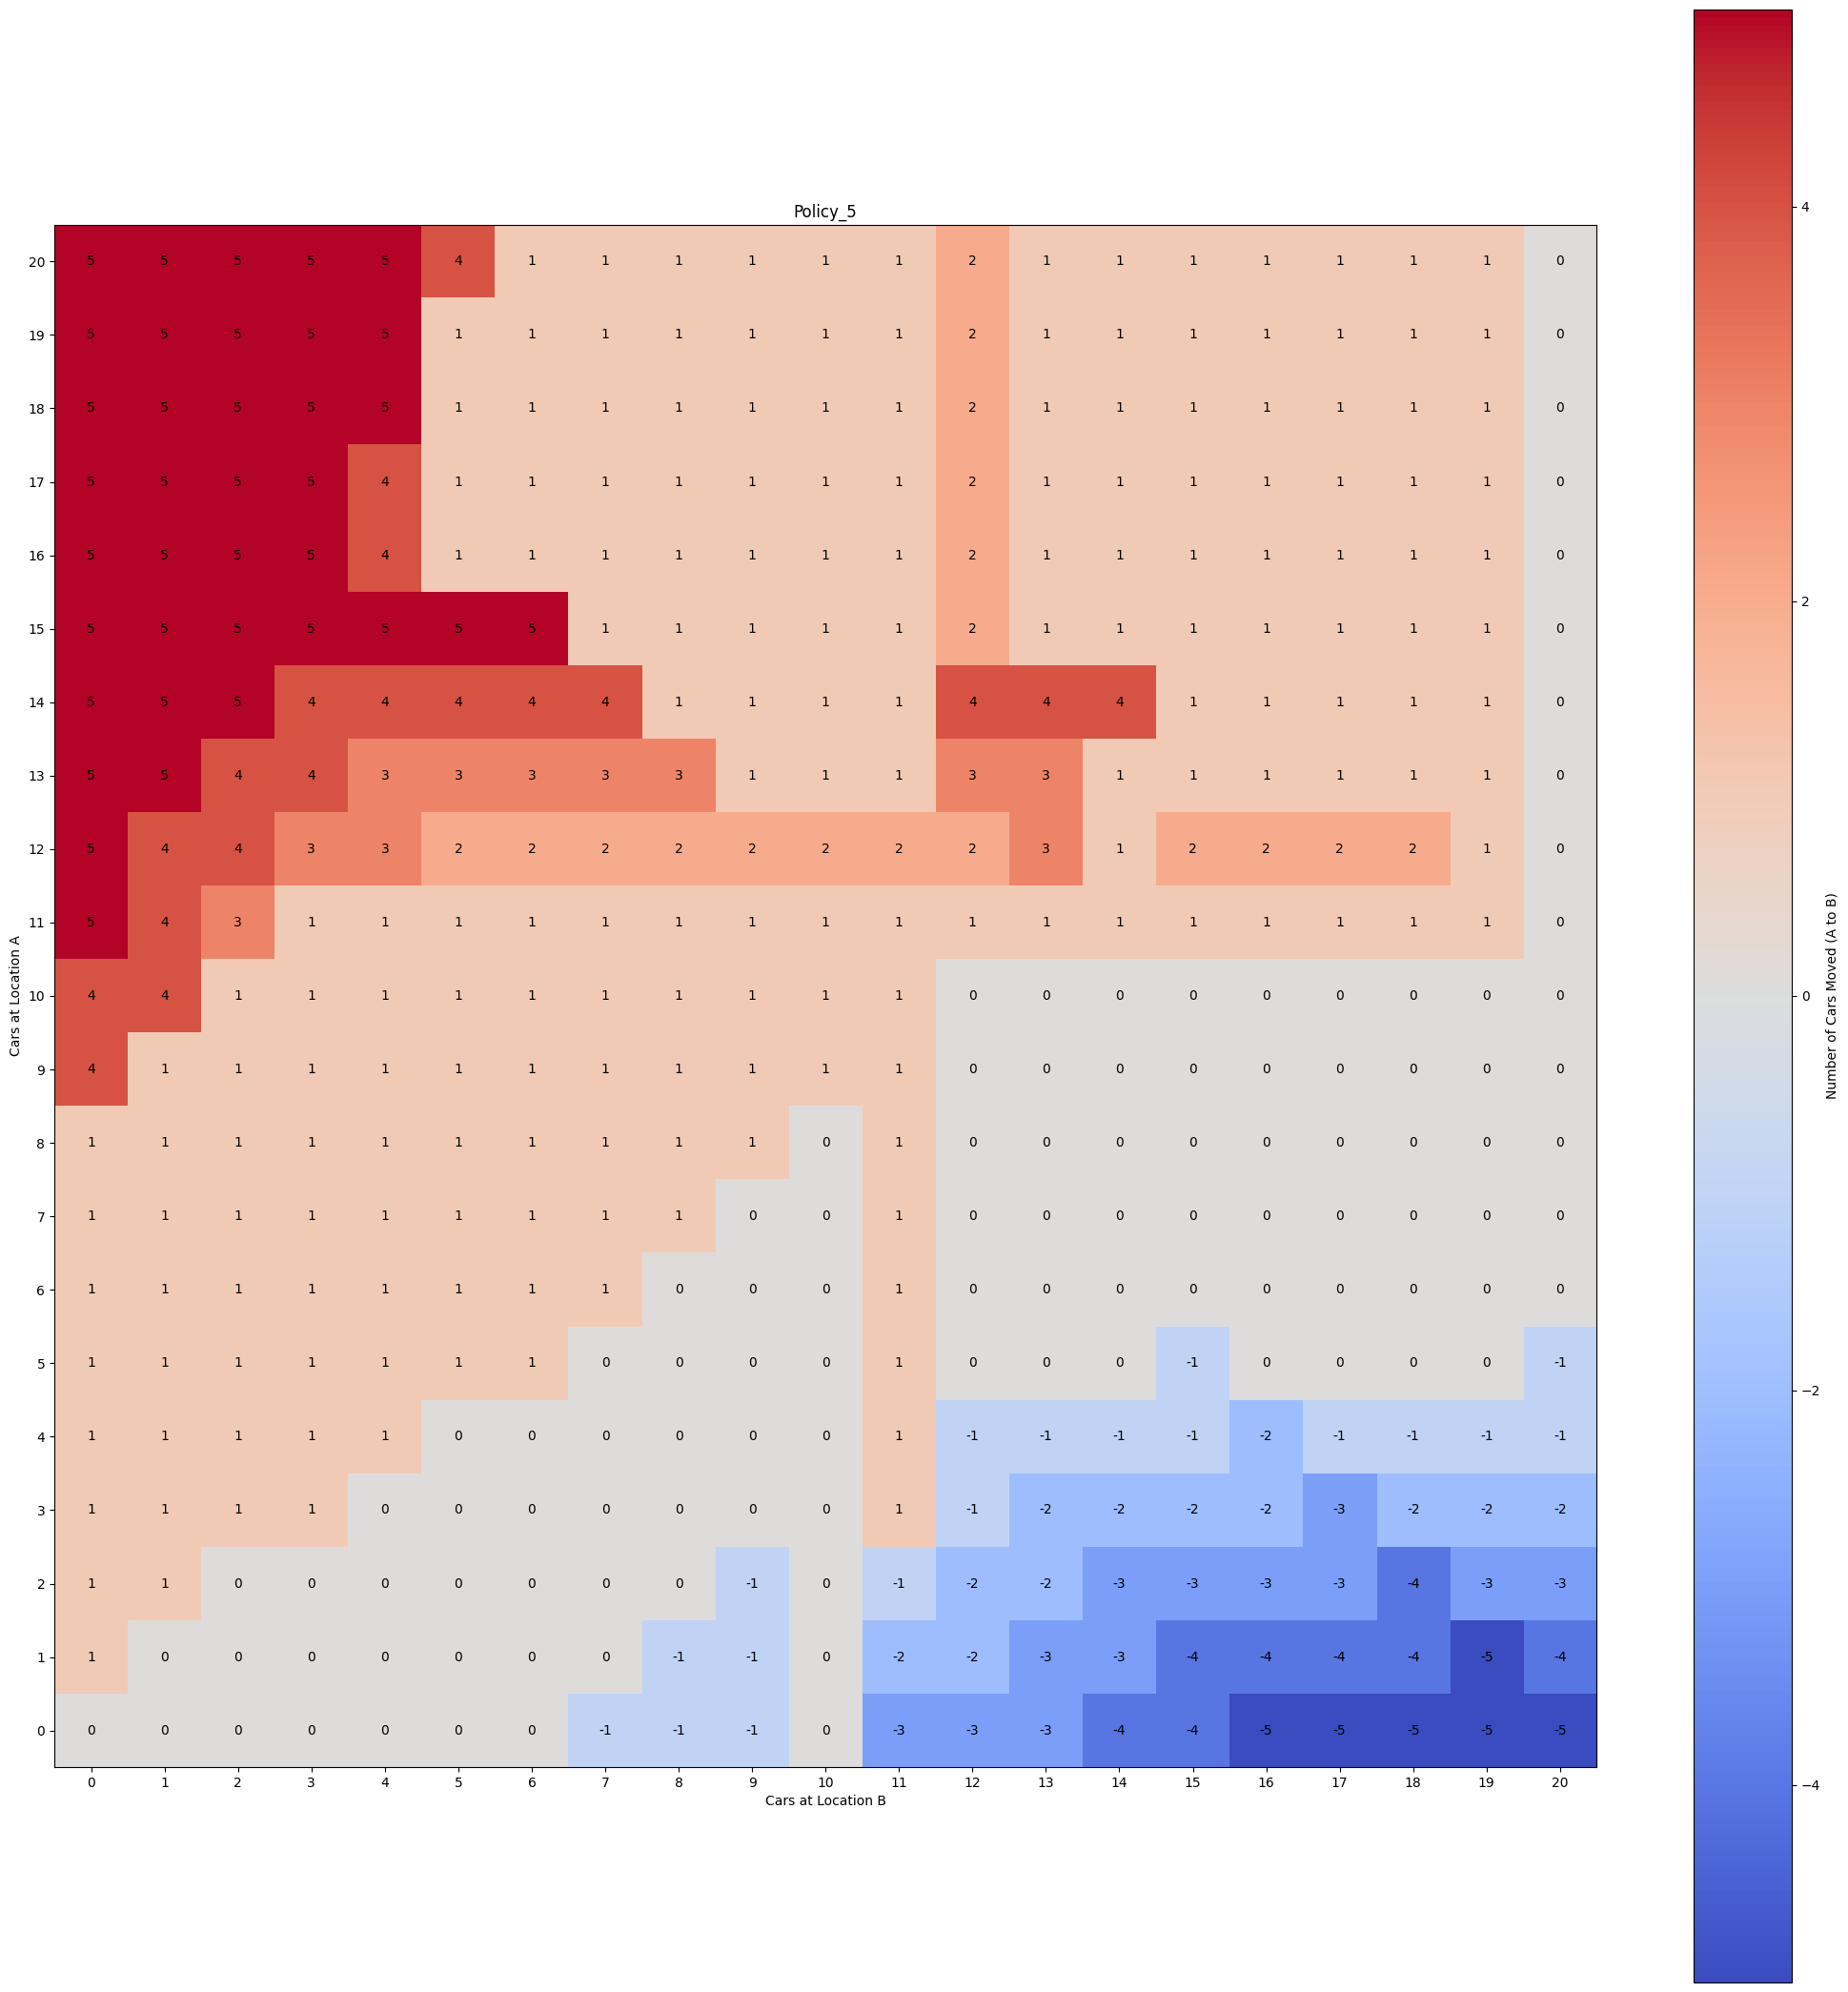

Conduct 5 time evaluation


441it [00:08, 53.39it/s] 


0.03845835465631353


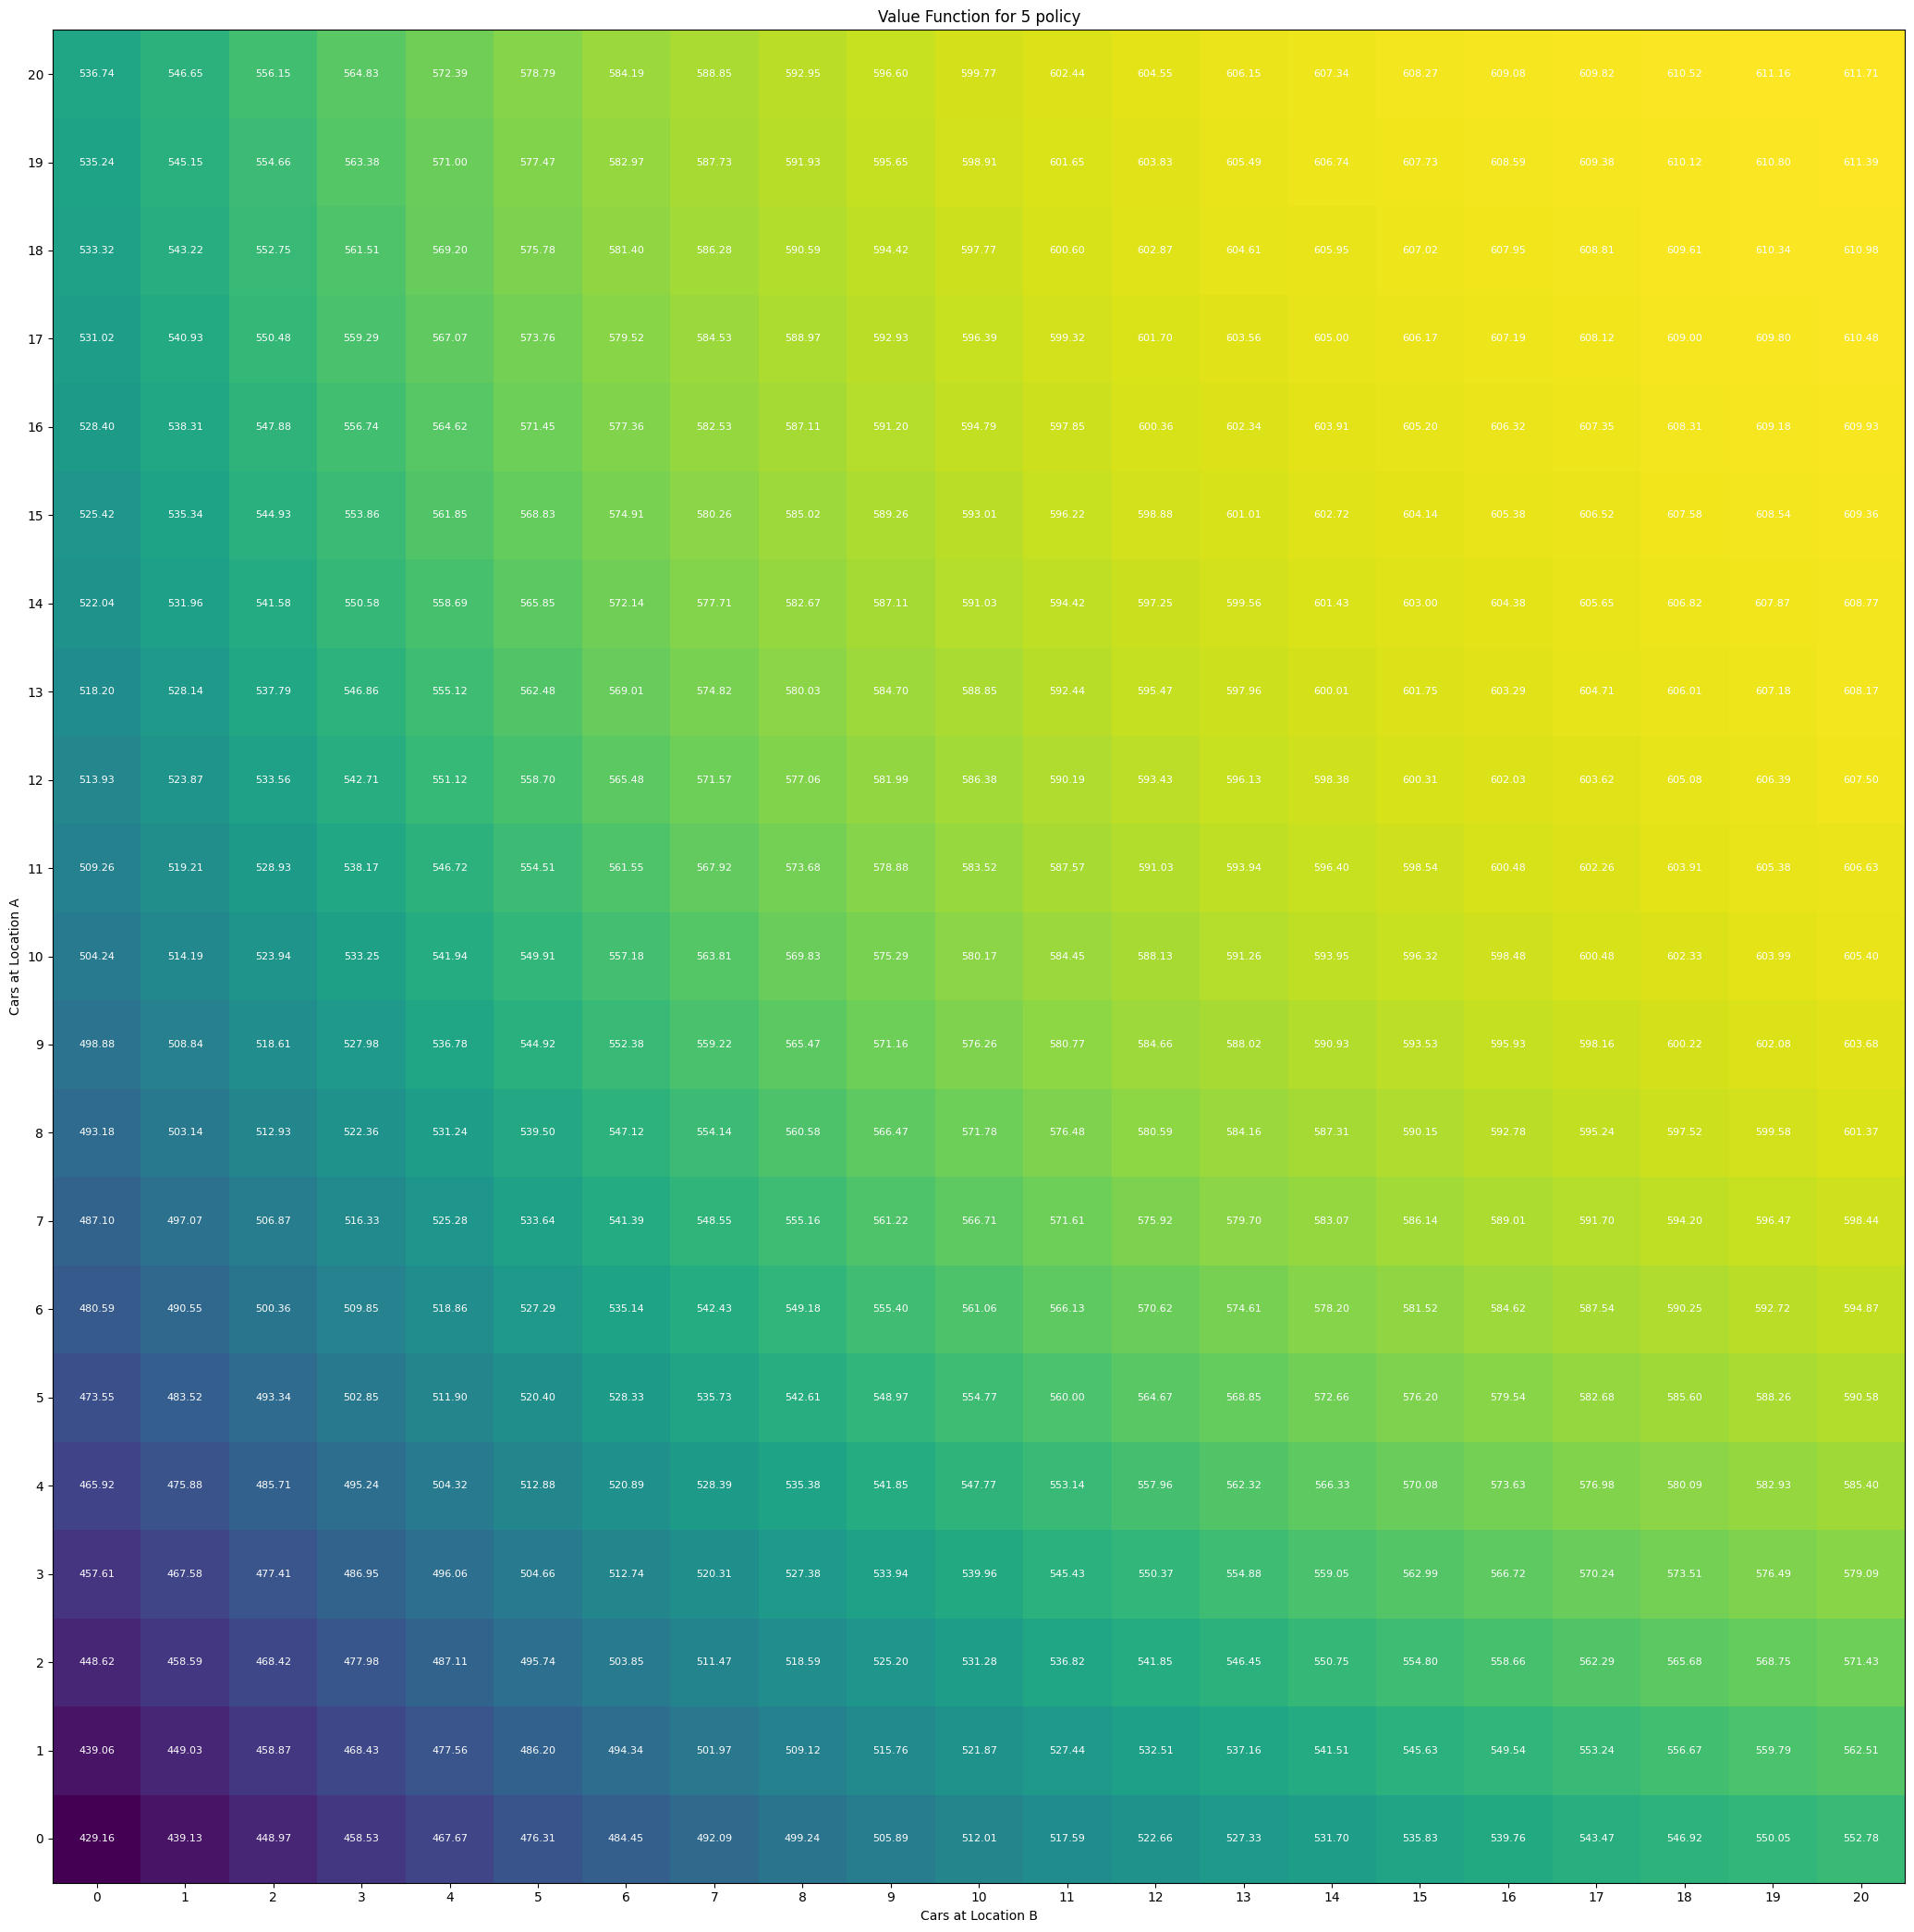

**********Staring 6 iteration


441it [00:00, 147092.49it/s]


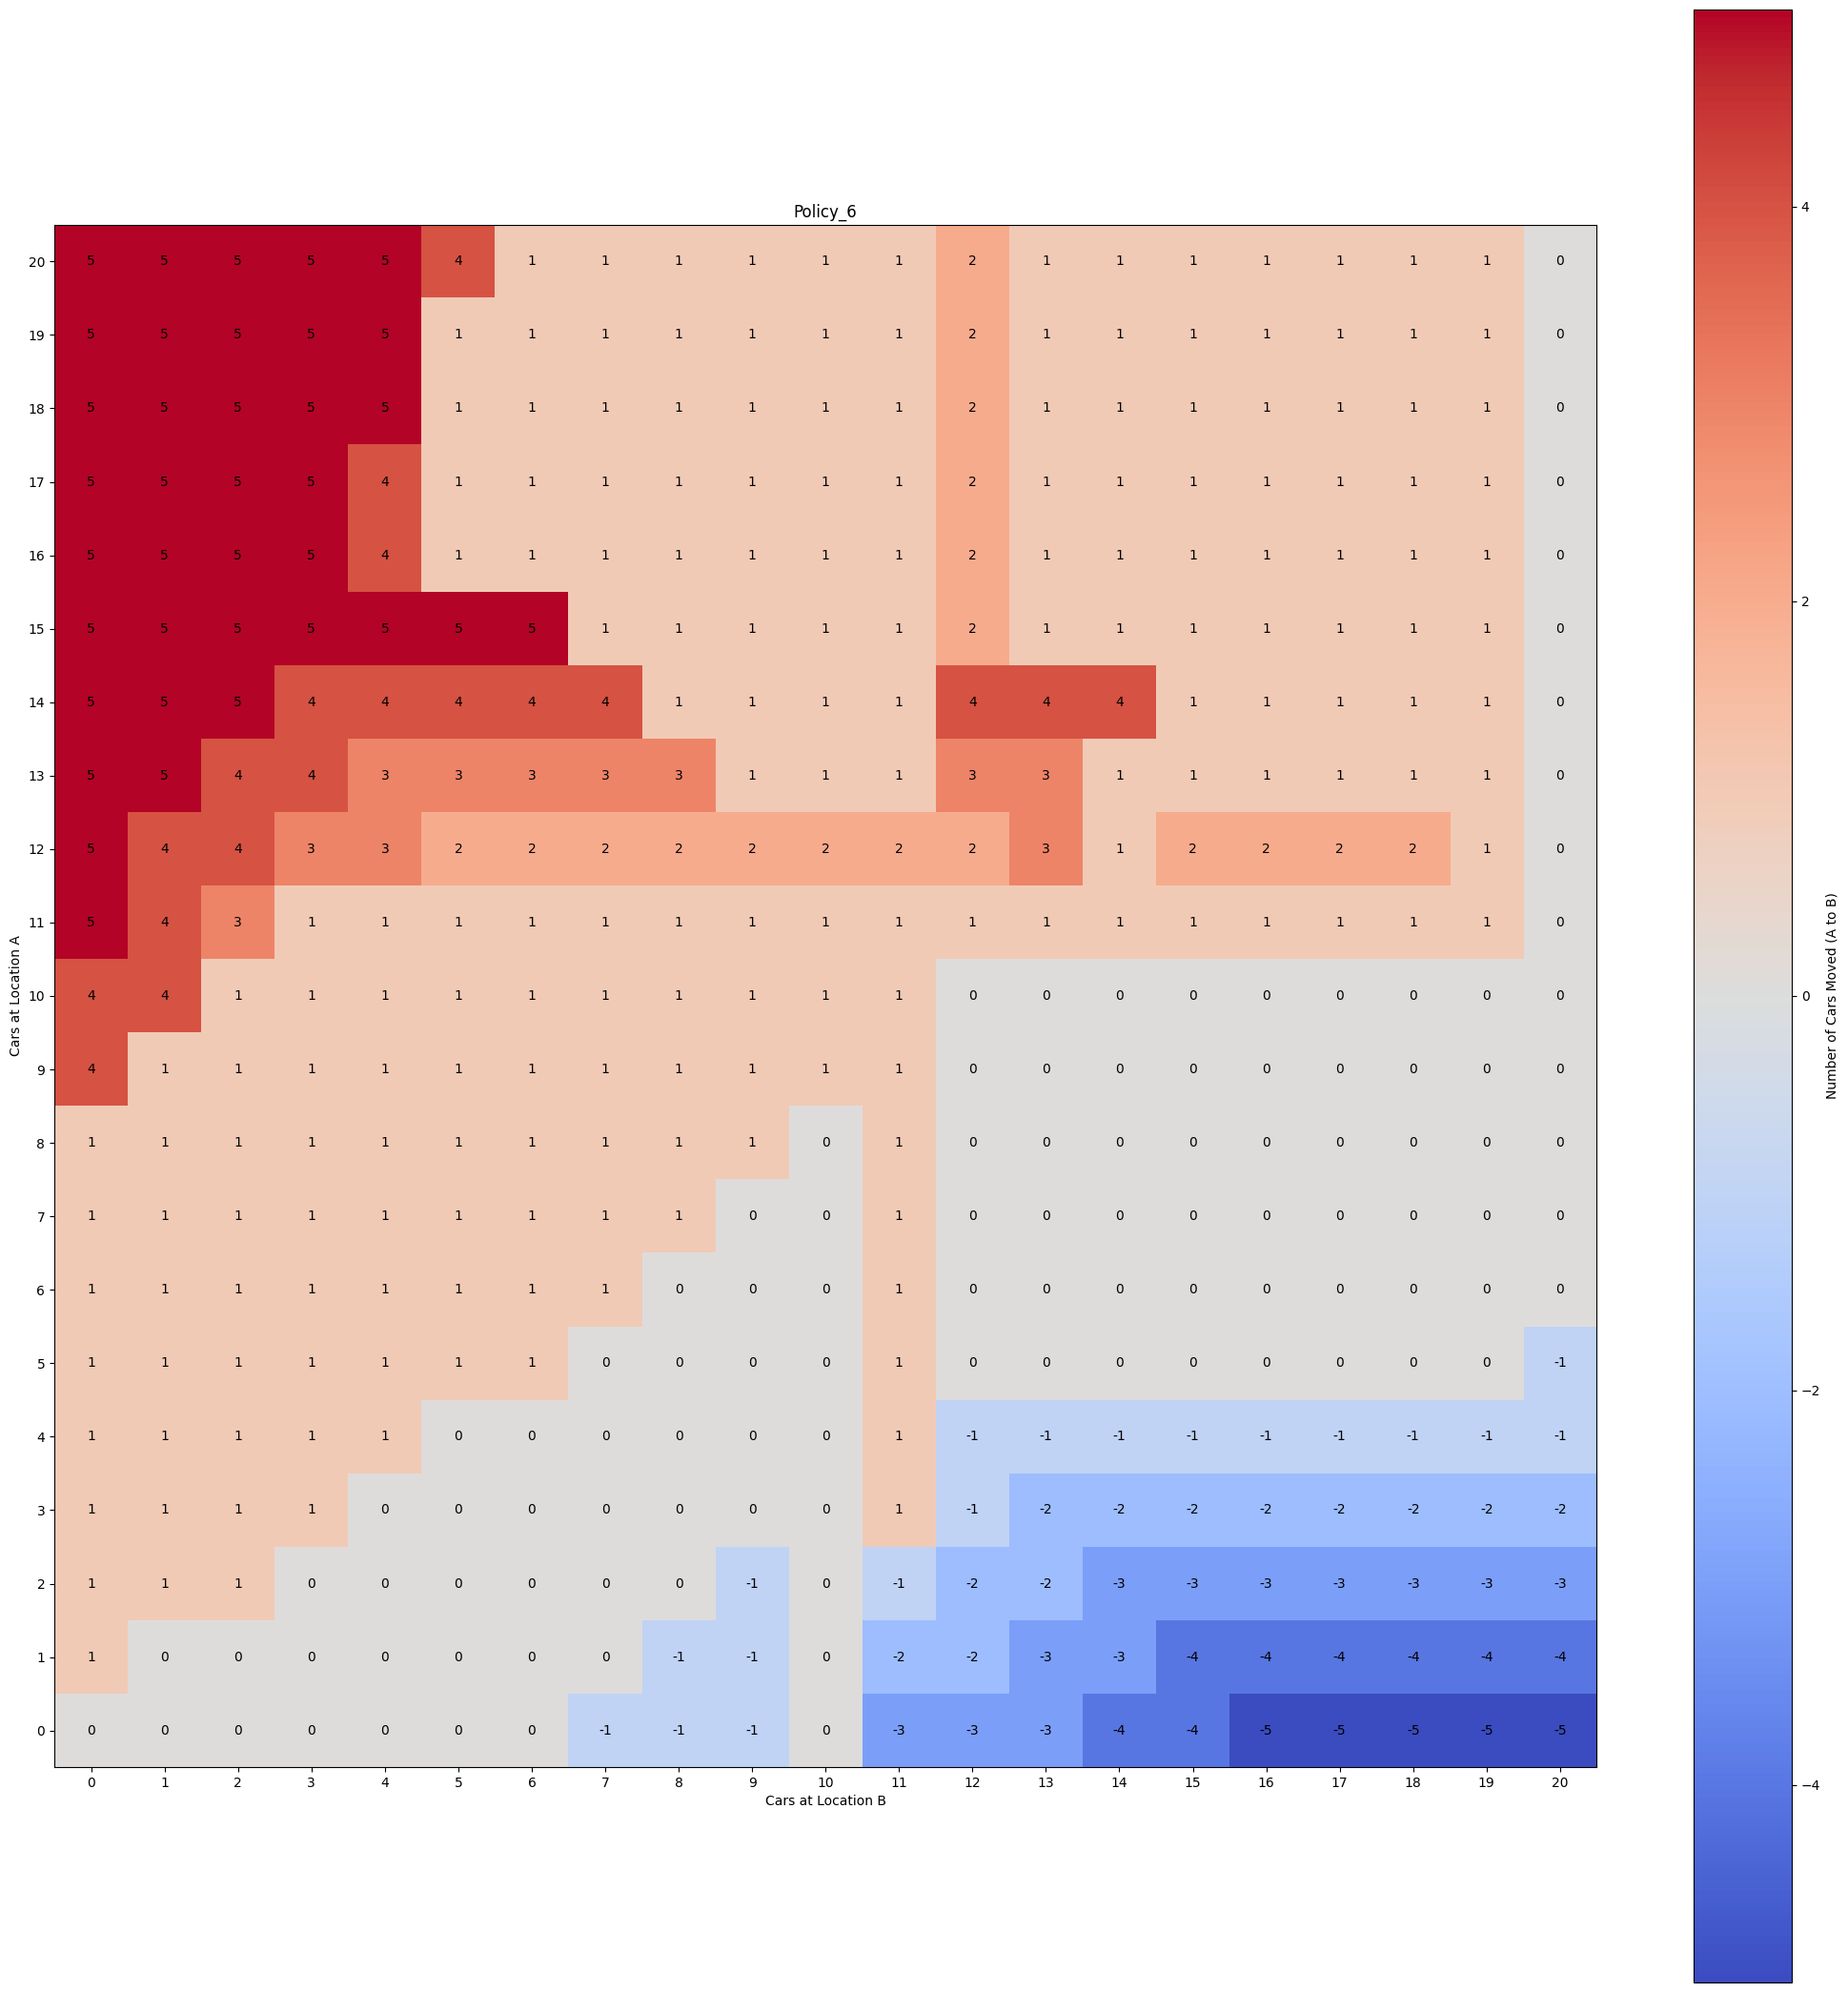

Conduct 6 time evaluation


441it [00:08, 53.11it/s] 


0.030489387744751184


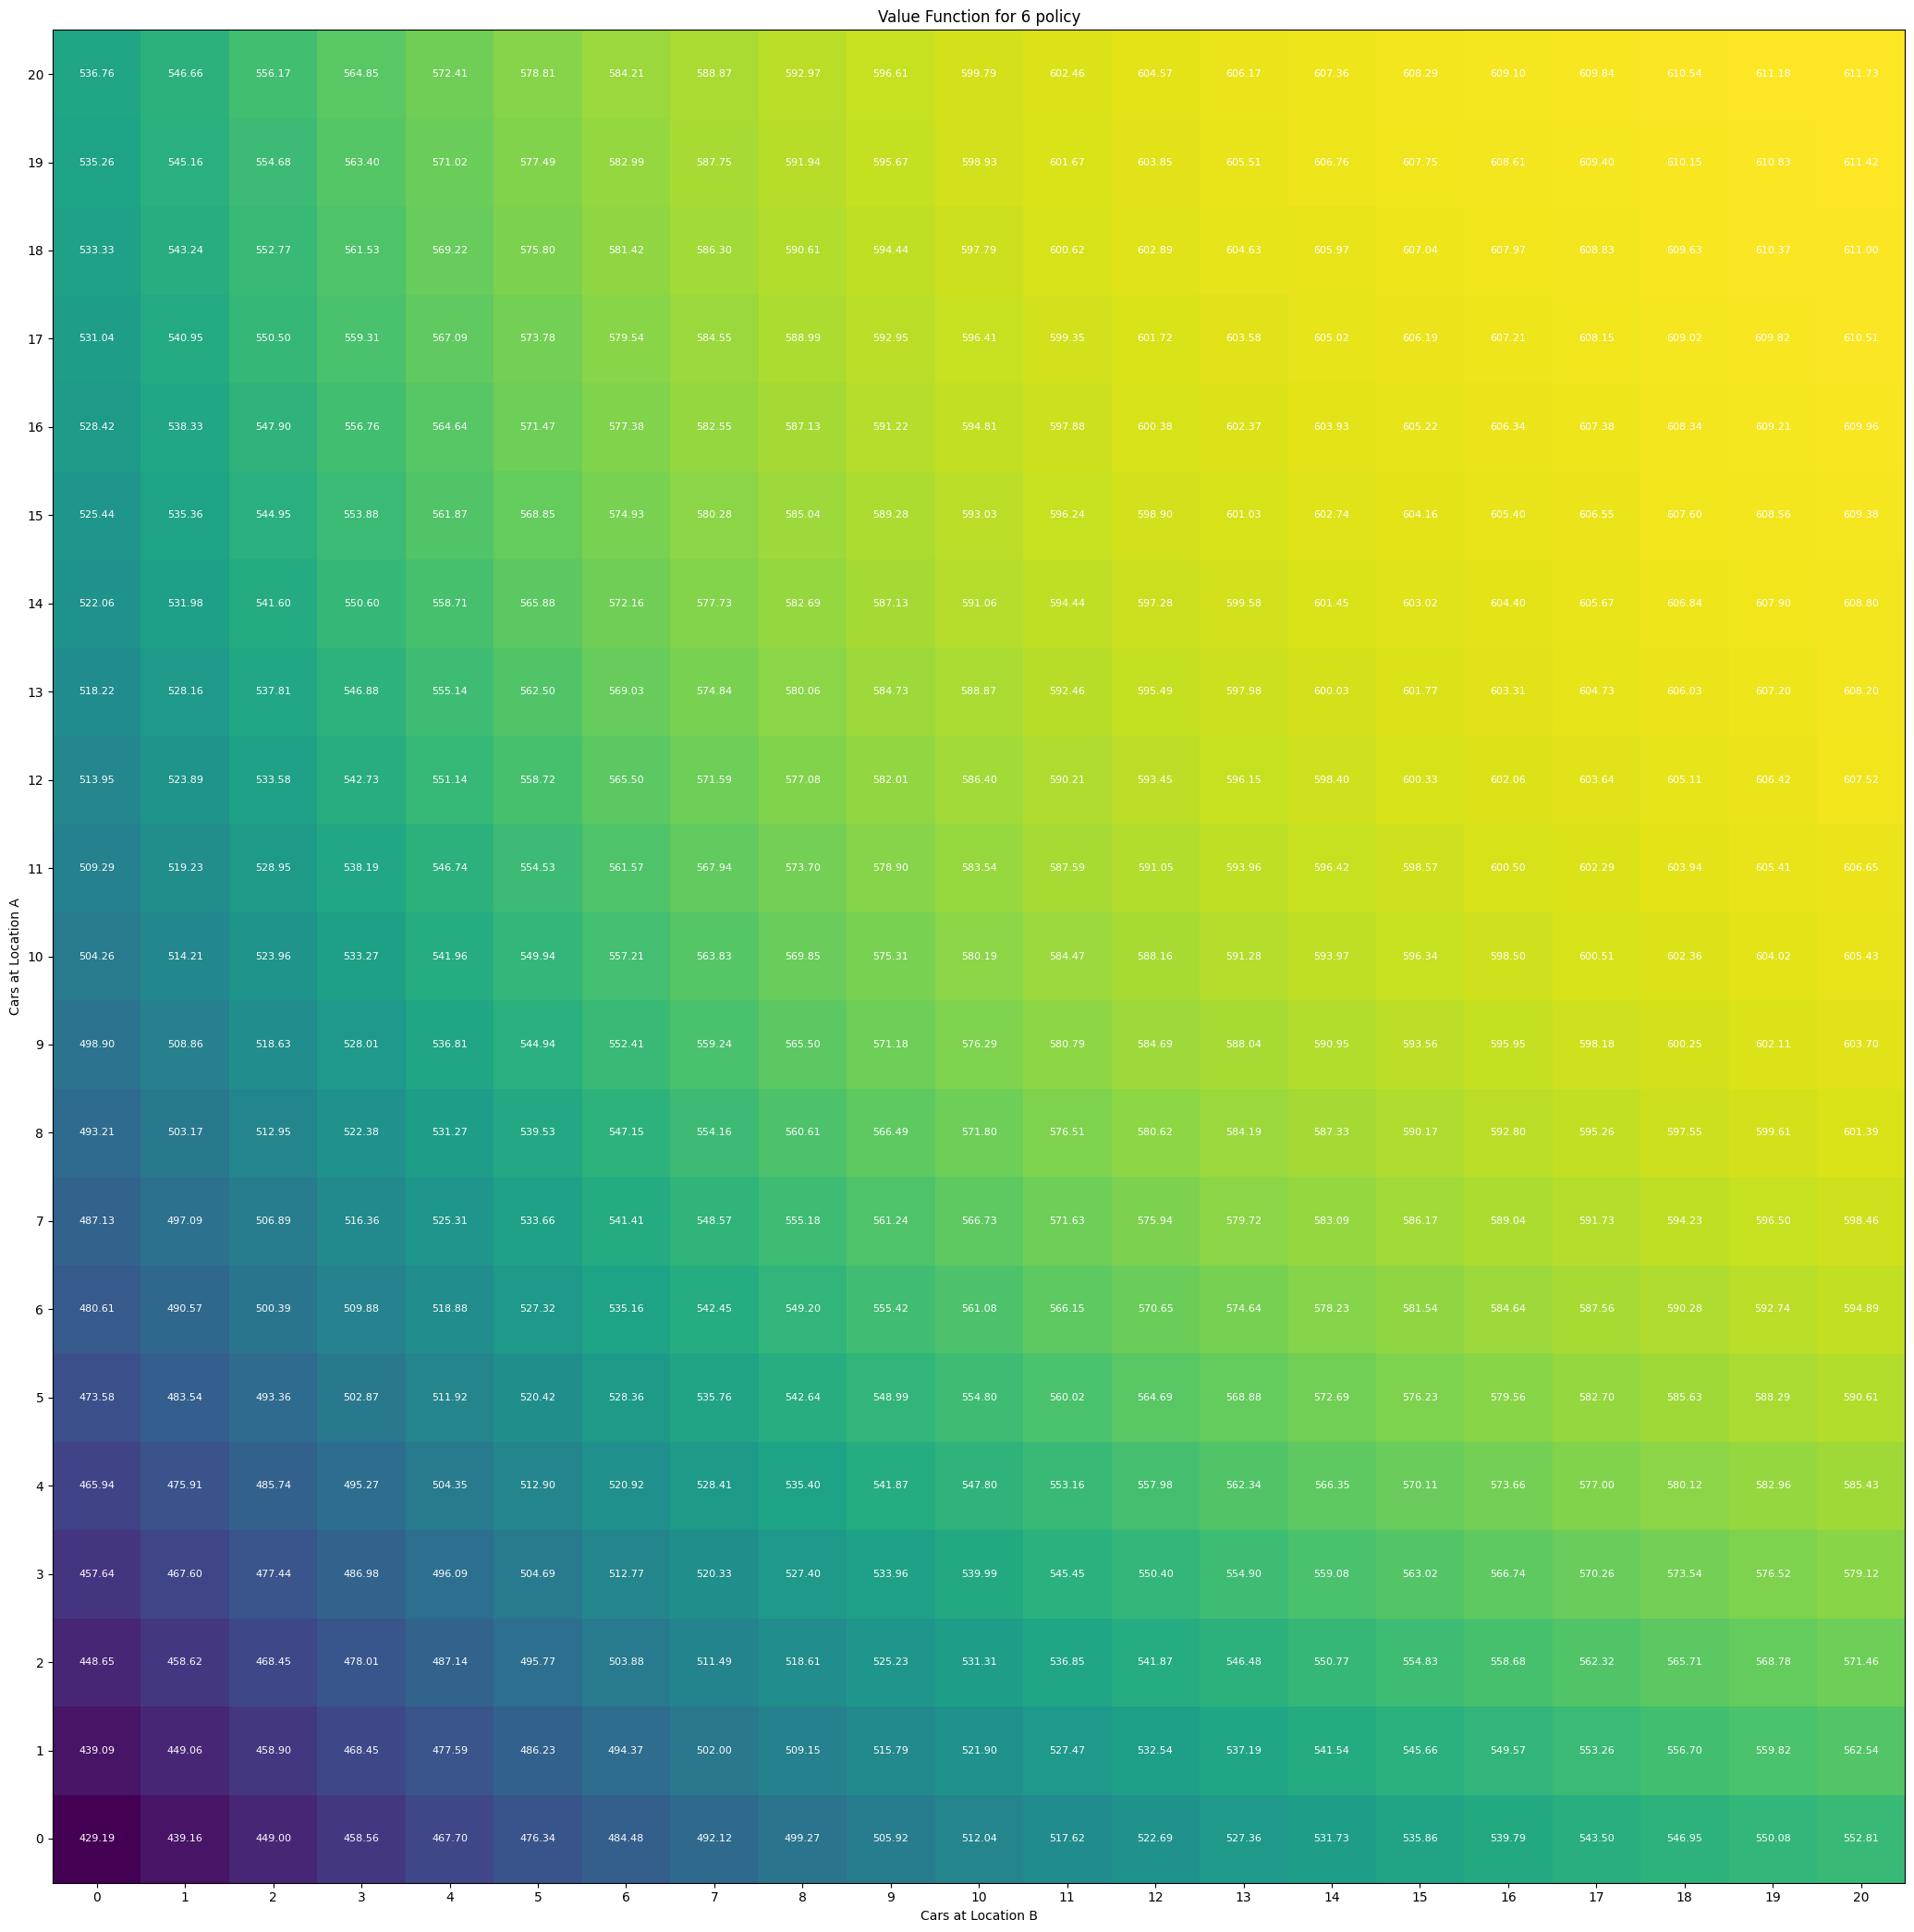

**********Staring 7 iteration


441it [00:00, 145484.35it/s]


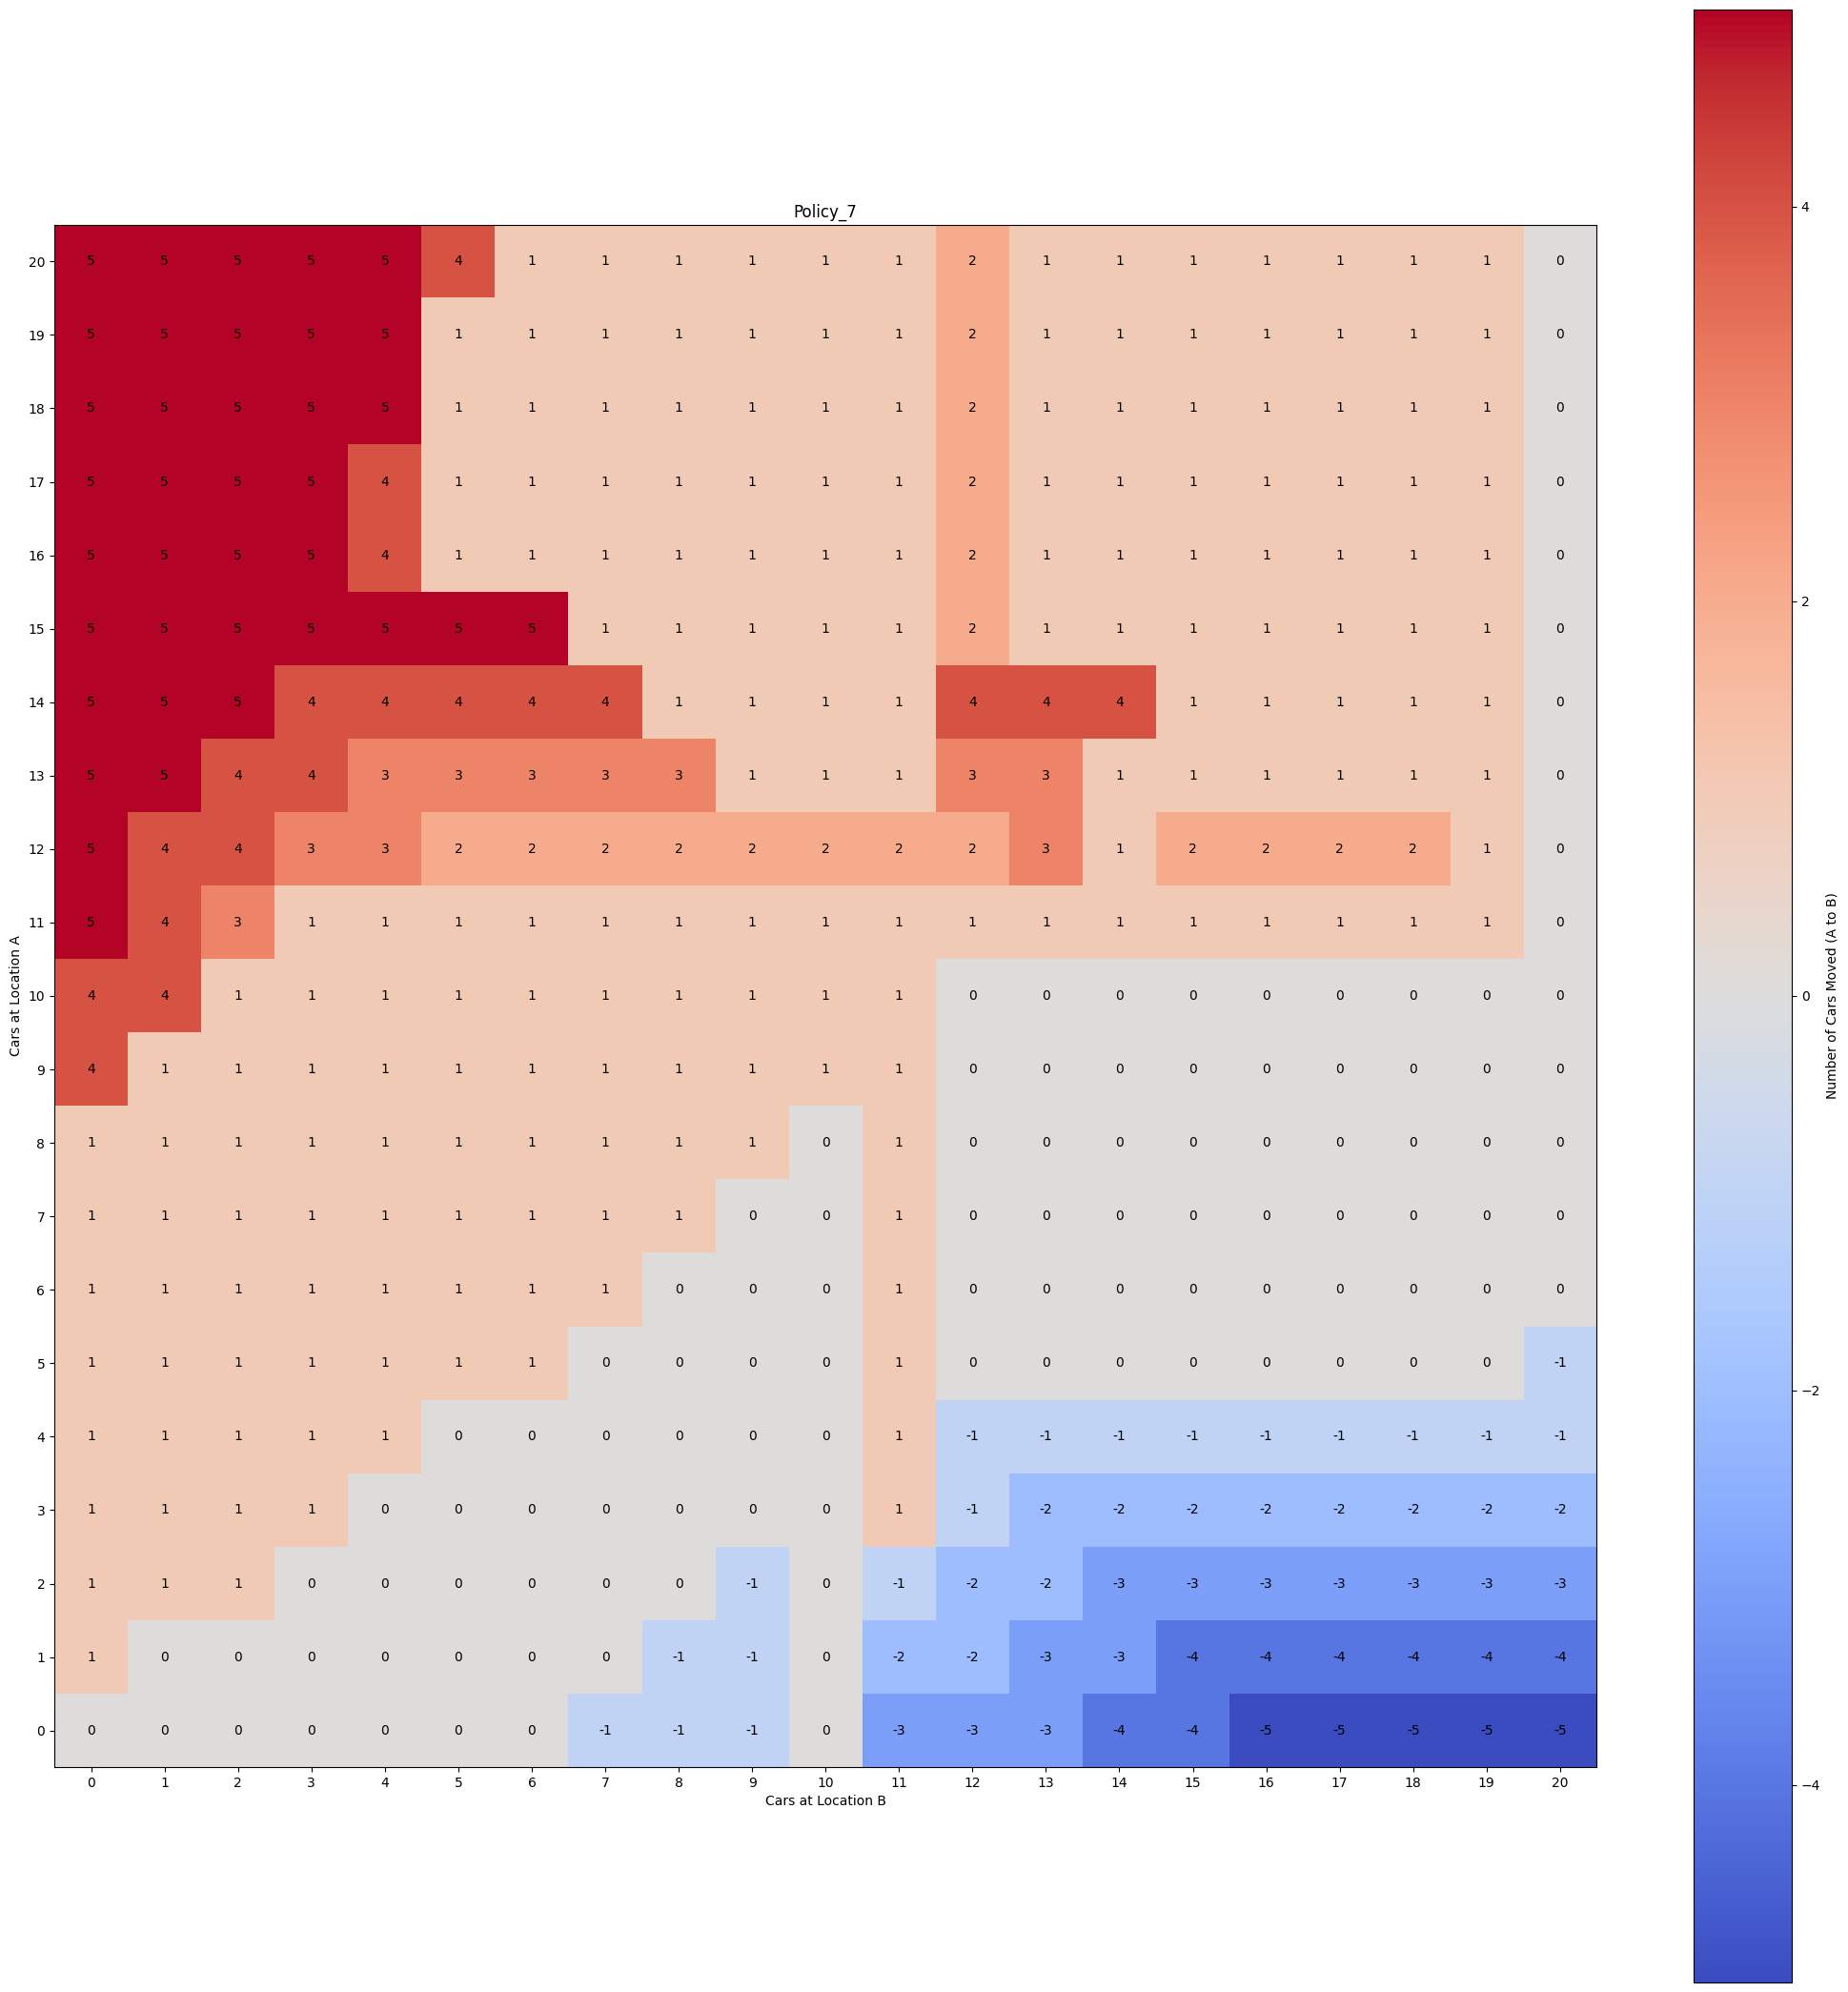

Policy reached optimal


In [7]:
agent = Agent()
policy_iteration_count = 0
print("Conduct initial Evaluation")
agent.evaluate()
while True:
    plot_value_table(agent.v_table, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    policy_iteration_count += 1
    print('*' * 10 + f"Staring {policy_iteration_count} iteration")
    policy_stable = True
    for i, j in tqdm(itertools.product(range(CAPACITY_A + 1), range(CAPACITY_B + 1))):
        old_action = agent.policy[(i, j)]
        # we need to get all action value of this state and select the maximum action value as the new policy
        action_range = range(max(-j, i - CAPACITY_A, -agent.max_action), min(i, CAPACITY_B - j, agent.max_action) + 1)
        state = (i, j)
        q_values = {}
        for action in action_range:
            action_value = 0.0
            s_a = i - action
            s_b = j + action
            afterstate = (s_a, s_b)
            afterstate_value = agent.v_table[afterstate]
            action_reward = agent.get_action_reward(state, action)

            action_value = afterstate_value + action_reward
            q_values[(i, j, action)] = action_value
        
        max_action = max(q_values, key=q_values.get)[2]
        agent.policy[(i, j)] = max_action
        if old_action != max_action:
            policy_stable = False

    plot_policy(agent.policy, policy_iteration_count, CAPACITY_A, CAPACITY_B)
    if policy_stable:
        print('Policy reached optimal')
        break
    print(f"Conduct {policy_iteration_count} time evaluation")
    agent.evaluate()
